# Imports and Utility Variables

In [1]:
import phoebe
from phoebe import u

import numpy as np
import matplotlib.pyplot as plt

import scienceplots
plt.style.use("science")

import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import importlib
import analisis.phoebe_model.utils as gen_utils
import analisis.phoebe_model.optimizers.opt_utils as opt_utils
importlib.reload(gen_utils)
importlib.reload(opt_utils)

logger = phoebe.logger(clevel='WARNING')

In [2]:
rawGaiaDatasets = ['lc_gaia_g_raw', 'lc_gaia_rp_raw', 'lc_gaia_bp_raw']
ztfDatasets = ['lcZtfG', 'lcZtfR']

allDatasetPlotGroups = [ztfDatasets, rawGaiaDatasets, ['lc_iturbide_norm']]

# Bundle Load and Prep

In [3]:
b = gen_utils.loadBundle("ebai-estimates-trimmed", parentFolder="../estimations", subfolder="updated-data")

100%|██████████| 407/407 [01:30<00:00,  4.52it/s]


before_optimizers
	 Gaia (Raw) - 13179.37953542073
		 lc_gaia_g_raw - 11176.208883803982
		 lc_gaia_rp_raw - 996.3473725101767
		 lc_gaia_bp_raw - 1006.8232791065728
------------------------------------------------
	 Iturbide (Norm) - 5252.176569719551
------------------------------------------------
	 ZTF - 16150.653296952174
		 lcZtfG - 5249.8536021738255
		 lcZtfR - 10900.799694778349


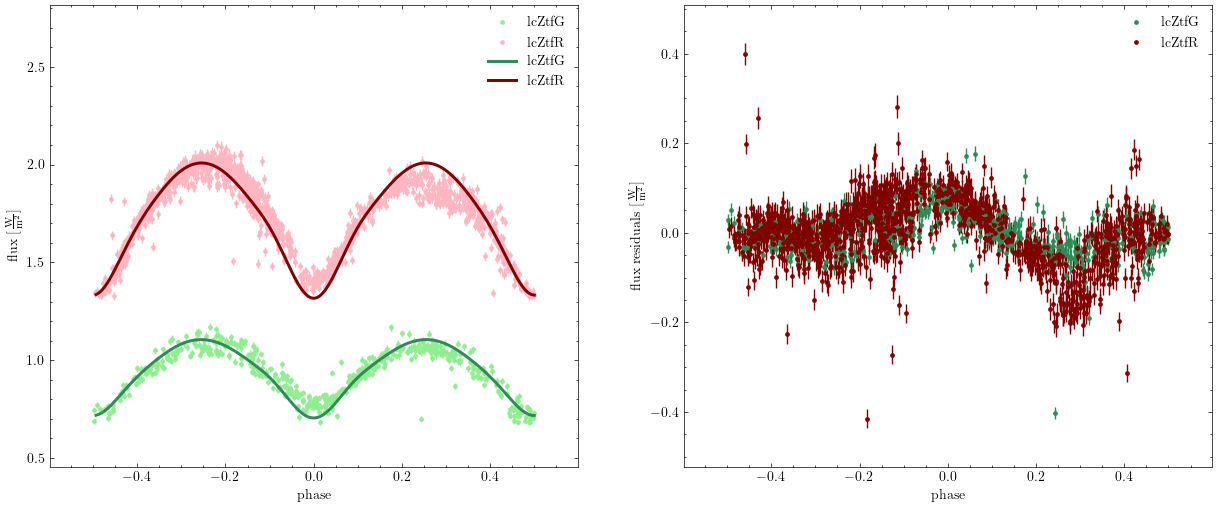

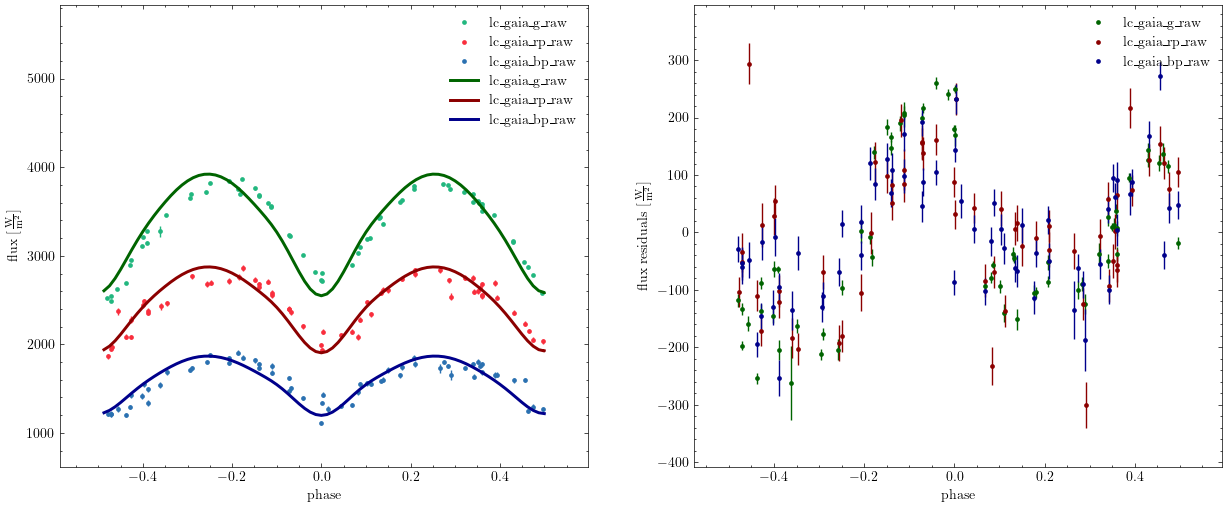

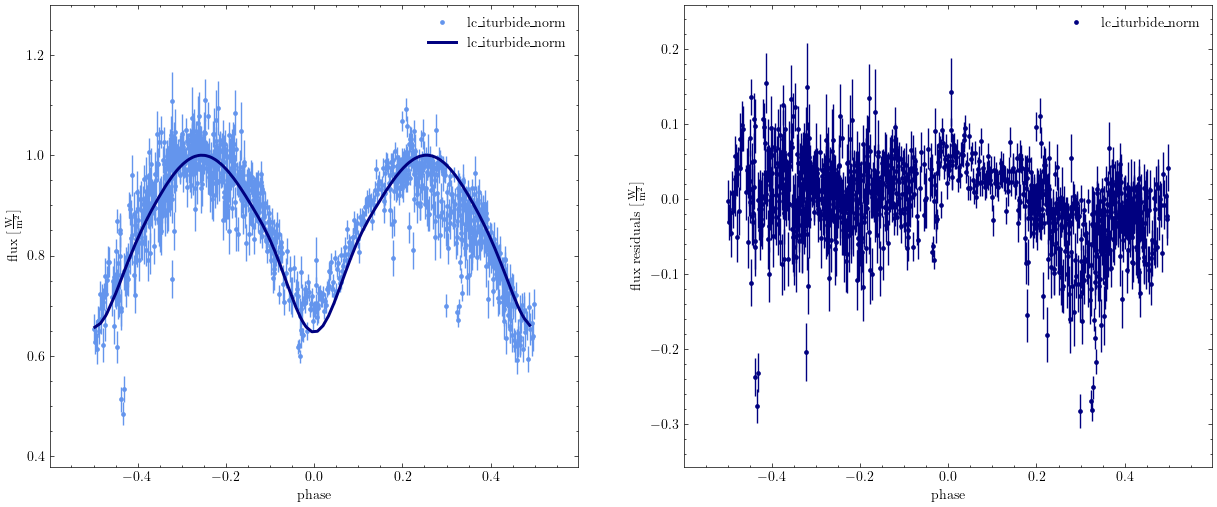

In [4]:
b.run_compute(model='before_optimizers', overwrite=True)
gen_utils.printChi2(b, 'before_optimizers')
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(15, 6), datasetGroups=allDatasetPlotGroups, model='before_optimizers')

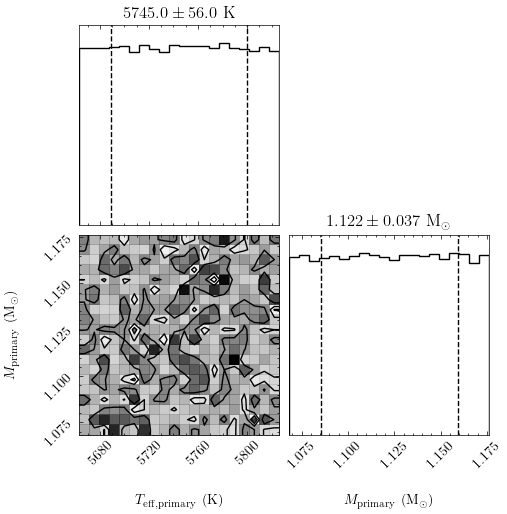

In [6]:
_ = b.plot_distribution_collection('poro_porb_bounds')

# Initial Parameters

## Sampling Poro Mass Distribution

Finding photometric solution using Poro empirical mass distribution. Primary component mass will be assumed to be sample.

In [5]:
poroDist, _ = b.get_distribution_collection('poro_porb_bounds')
_, massSample = poroDist.sample()
print(f"Sampled mass: {massSample}")
# b.set_value(qualifier='mass', component='primary', context='component', value=massSample)

# manually indirectly setting secondary's mass to sample
	# obtaining photometric solution for low mass components, to coincide with spectrum
	# true masses cannot be known without RV curve
primaryMass = massSample / b.get_value(qualifier='q')
b.set_value(qualifier='mass', component='primary', context='component', value=primaryMass)
b.run_all_constraints()
print(b['mass'])

Sampled mass: 1.1109318129164283
ParameterSet: 4 parameters
           mass@primary@component: 0.5744817855962876 solMass
C        mass@secondary@component: 1.1109318129164278 solMass
                  mass@constraint: (39.478418 * ({sma@binary@component} ** 3.000000)) / ((({period@binary@component} ** 2.000000) * ((1.000000 / {q@binary@component}) + 1.000000)) * 2942.206217504419328179210424423218)
   mass@poro_porb_bounds@distr...: <distl.uniform low=1.0683296468664136 high=1.1763645528088365 unit=solMass label=mass@primary label_latex=$M_\mathrm{ primary }$>


100%|██████████| 407/407 [01:27<00:00,  4.66it/s]


poro_sample
	 Gaia (Raw) - 13198.59739272794
		 lc_gaia_g_raw - 11194.140876486304
		 lc_gaia_rp_raw - 996.4022698506573
		 lc_gaia_bp_raw - 1008.0542463909775
------------------------------------------------
	 Iturbide (Norm) - 5255.932609275021
------------------------------------------------
	 ZTF - 16179.005343185534
		 lcZtfG - 5268.239817191116
		 lcZtfR - 10910.765525994419


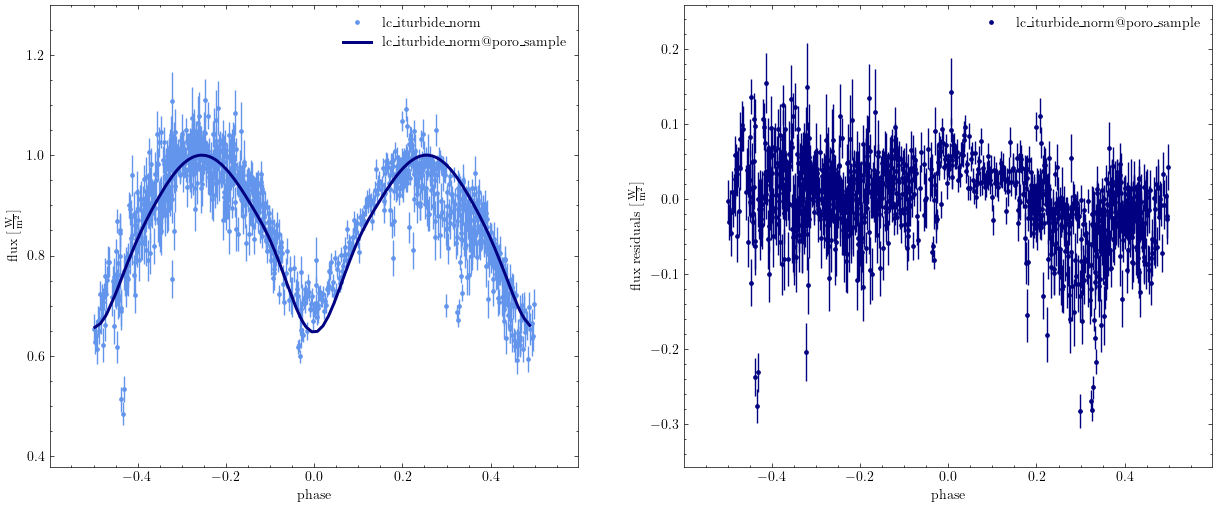

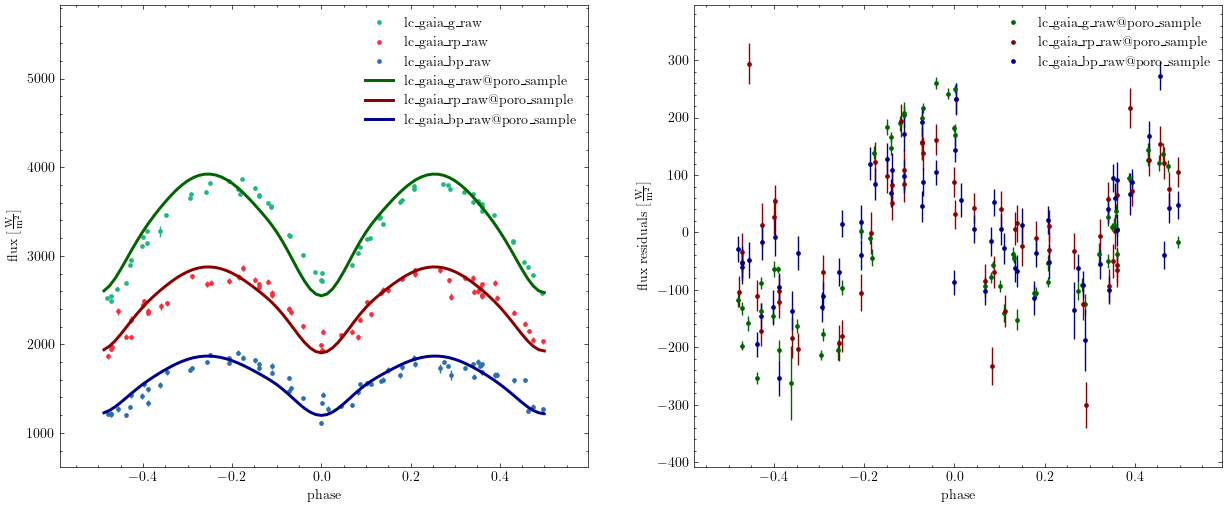

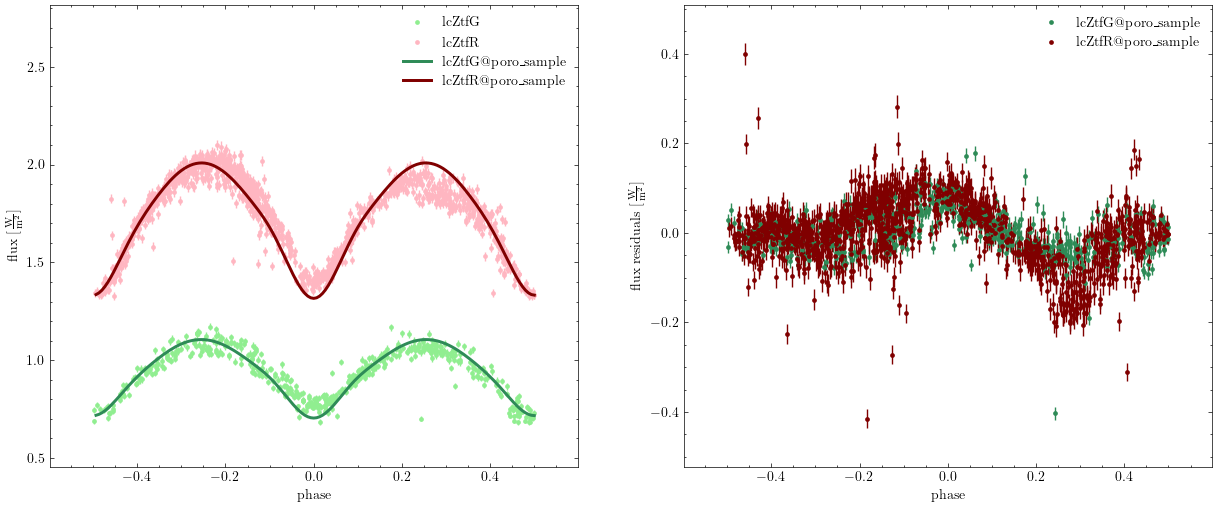

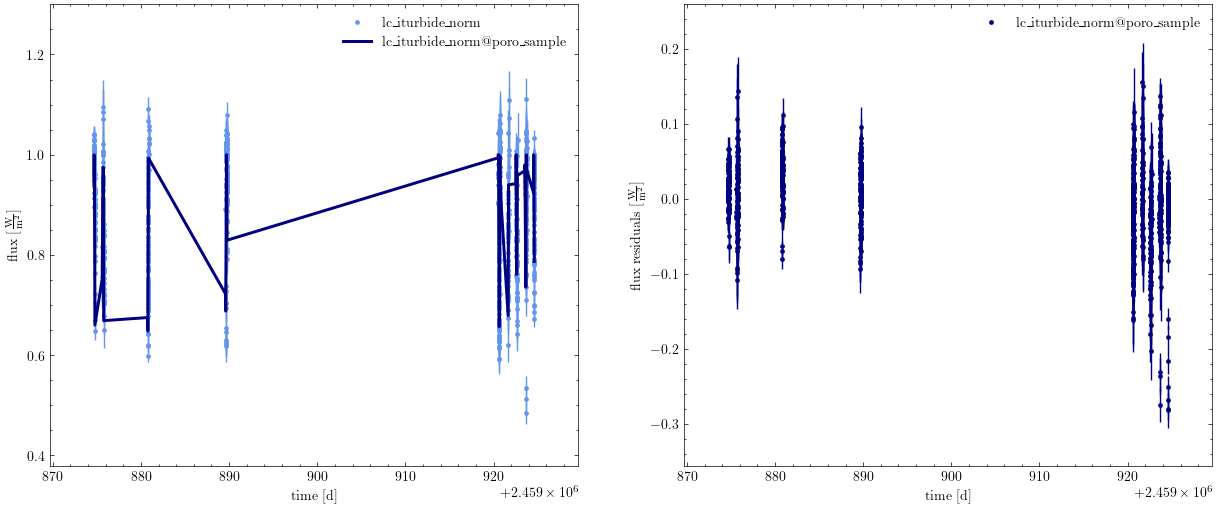

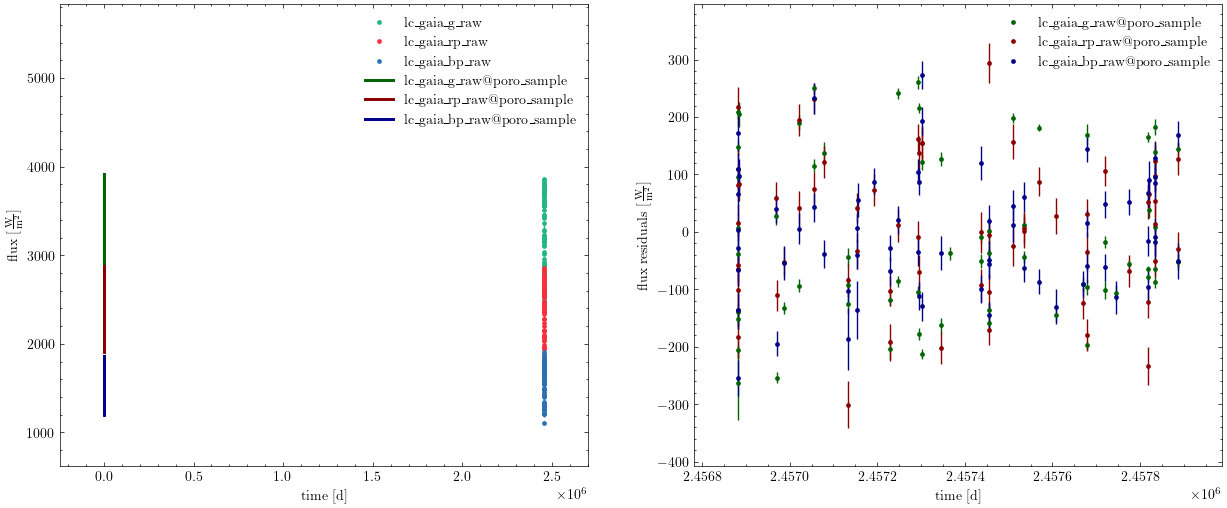

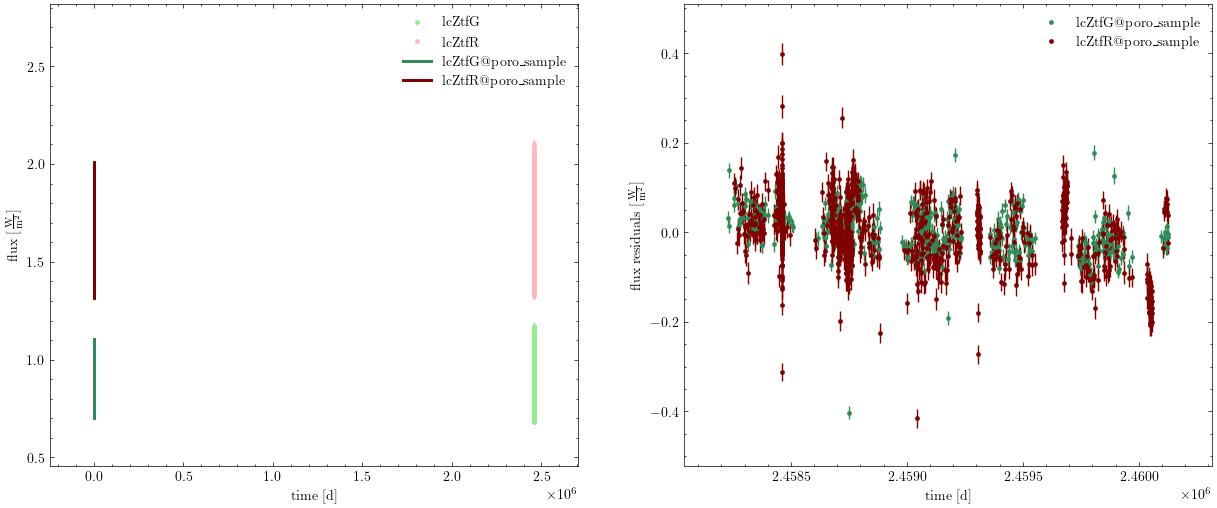

In [6]:
gen_utils.abilitateDatasets(b, ['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets)
b.run_compute(model='poro_sample', overwrite=True)
gen_utils.printChi2(b, 'poro_sample')
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(15, 6), datasetGroups=[['lc_iturbide_norm'], rawGaiaDatasets, ztfDatasets], model='poro_sample')
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(15, 6), datasetGroups=[['lc_iturbide_norm'], rawGaiaDatasets, ztfDatasets], model='poro_sample', phase=False)

In [7]:
print(b['q'])
print(b['mass'])
print(b['requiv'])
print(b['teff'])
print(b['teffratio'])
print(b['fillout_factor'])
print(b['incl@binary'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 1.9337981477747437
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@binary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, period@binary@component, sma@primary@component, incl@bina

# `t0_supconj`

Eclipse timings look off from model to light curves, from slight positional offset.

100%|██████████| 407/407 [01:23<00:00,  4.85it/s]


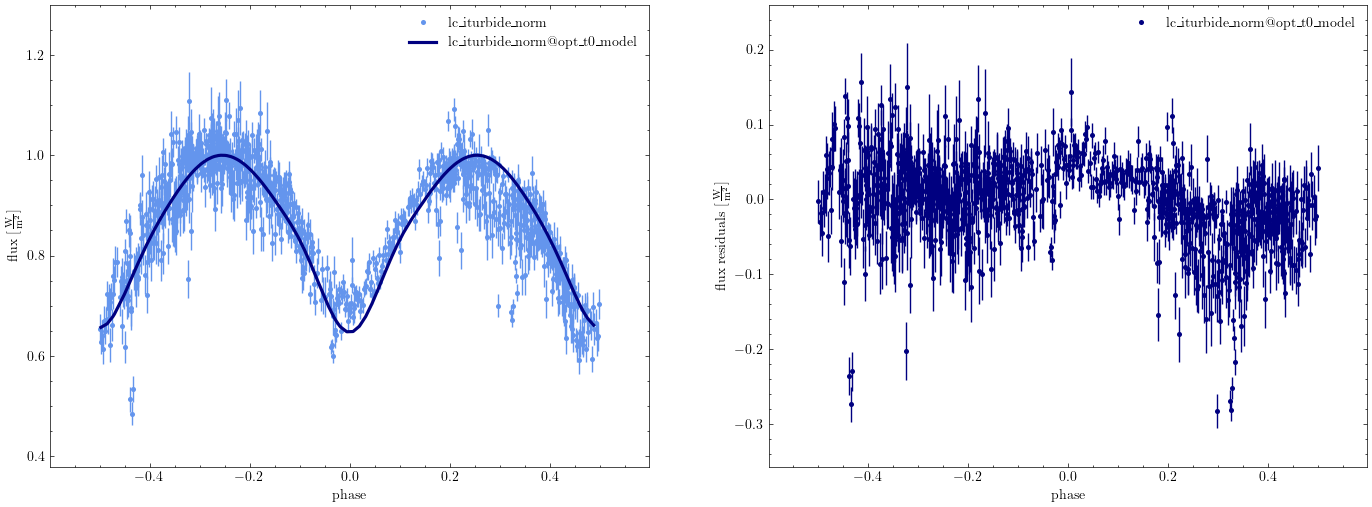

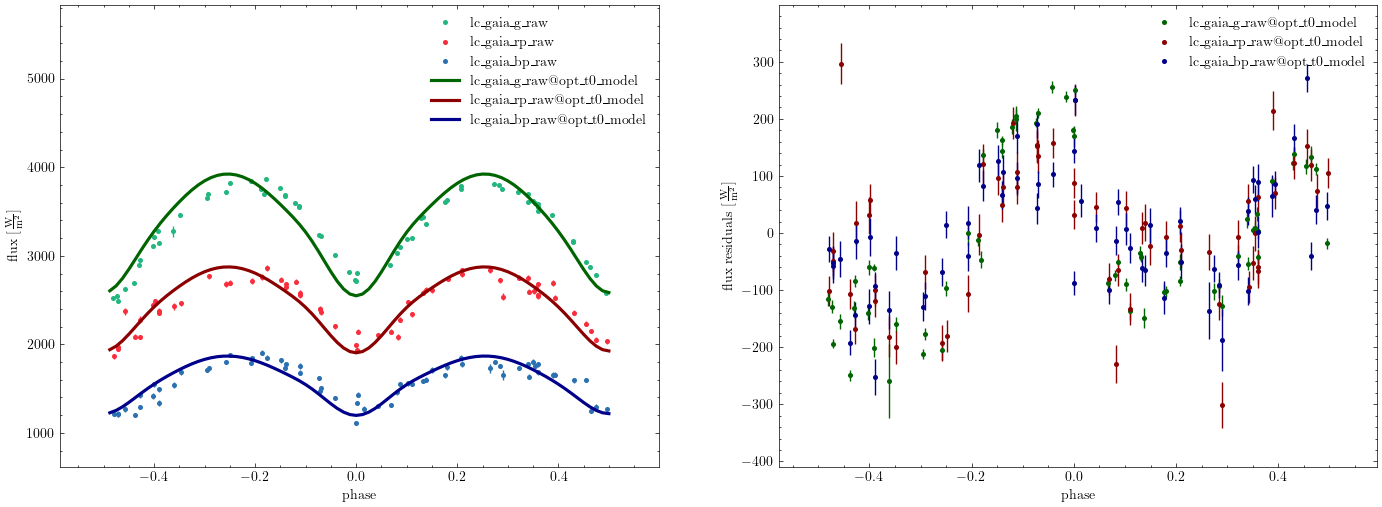

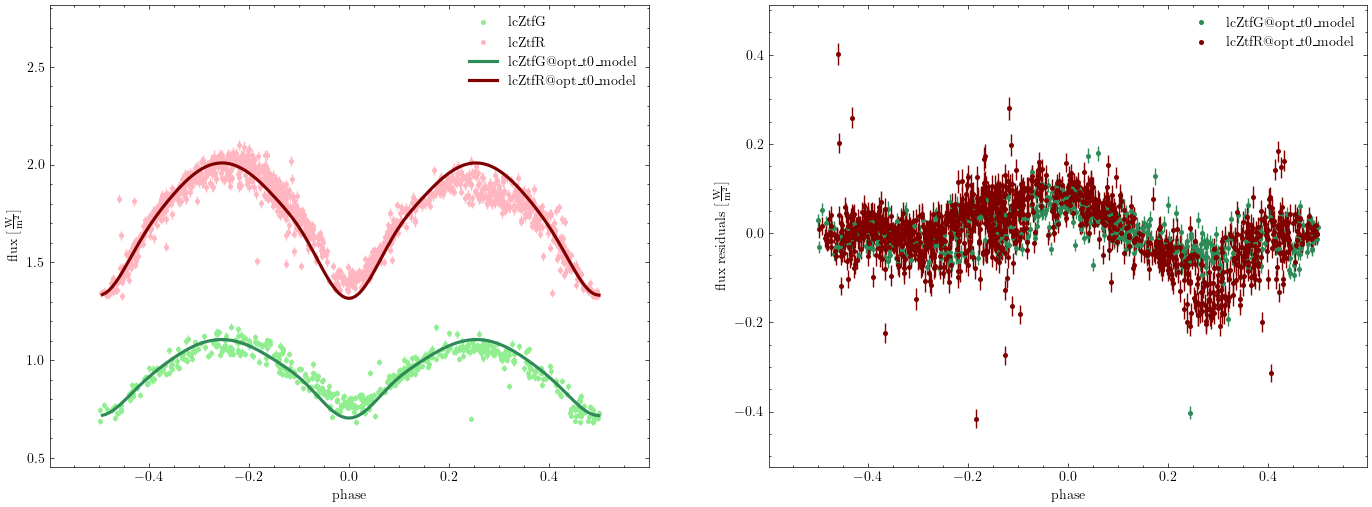

In [7]:
# opt_utils.optimize_params(b, fit_twigs=['t0_supconj'], label='t0', export=False, datasets=ztfDatasets, maxiter=50)

gen_utils.abilitateDatasets(b, ['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets)
b.set_value(qualifier='t0_supconj', value=0.02589*u.day) # result of below optimizer
b.run_compute(model='opt_t0_model', overwrite=True)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(17, 6), datasetGroups=[['lc_iturbide_norm'], rawGaiaDatasets, ztfDatasets], model='opt_t0_model')

In [11]:
%%script echo "skipping; already ran and hard-coded above"
gen_utils.abilitateDatasets(b, ['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets)
# solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-ltt/results/opt_per_t0_solution", reset_params=False)
# solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/updated-data/results/opt_per_t0_solution", reset_params=False)
# solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/updated-data/results/opt_t0_solution", reset_params=True)
solutionName, computeModelName = opt_utils.adopt_solution(b, label='t0', reset_params=False)
gen_utils.printAllModelsChi2(b)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(17, 6), datasetGroups=[['lc_iturbide_norm'], rawGaiaDatasets, ztfDatasets], model=computeModelName)

skipping; already ran and hard-coded above


<!-- # Eclipse Width and Depth

Adjusting $T_{eff}$ ratio (`teffratio`) based on eclipse depths, alongside the fillout factor (`fillout_factor`) to adjust the eclipse widths. Fillout factor
parametrization of component radii. -->
# NM Optimization

Adjusting parameters that affect general shape of LC. Using only ZTF data since it's the cleanest.

In [12]:
# opt_utils.optimize_params(b, ['teffratio', 'fillout_factor'], "teffr_ff", export=True, subfolder="updated-data", datasets=ztfDatasets, maxiter=200)
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'fillout_factor', 'incl@binary', 'q'], label="nm_all", 
                          export=True, subfolder="updated-data", datasets=ztfDatasets, maxiter=200)

External Solver: ./external-jobs/updated-data/optimizer.nelder_mead_opt_nm_all.py ./results/opt_nm_all_solution


('opt_nm_all', 'opt_nm_all_solution')

In [13]:
print(b['*bol*'])

ParameterSet: 14 parameters
      gravb_bol@primary@component: 0.32
   irrad_frac_refl_bol@primary...: 0.6
C  irrad_frac_lost_bol@primary...: 0.4
    ld_mode_bol@primary@component: lookup
    ld_func_bol@primary@component: logarithmic
   ld_coeffs_source_bol@primar...: auto
    gravb_bol@secondary@component: 0.32
   irrad_frac_refl_bol@seconda...: 0.6
C  irrad_frac_lost_bol@seconda...: 0.4
   ld_mode_bol@secondary@compo...: lookup
   ld_func_bol@secondary@compo...: logarithmic
   ld_coeffs_source_bol@second...: auto
   irrad_frac_lost_bol@primary...: 1.000000 - {irrad_frac_refl_bol@primary@component}
   irrad_frac_lost_bol@seconda...: 1.000000 - {irrad_frac_refl_bol@secondary@component}


In [14]:
print(b['irrad_frac_refl_bol@primary'])
print(b['irrad_frac_lost_bol@primary@component'])
print(b['irrad_method'])
print(b['gravb_bol@primary'])

Parameter: irrad_frac_refl_bol@primary@component
                       Qualifier: irrad_frac_refl_bol
                     Description: ratio of incident bolometric light that is used for reflection/irradiation (heating without redistribution)
                           Value: 0.6
                  Constrained by: 
                      Constrains: irrad_frac_lost_bol@primary@component
                      Related to: irrad_frac_lost_bol@primary@component

Parameter: irrad_frac_lost_bol@primary@component
                       Qualifier: irrad_frac_lost_bol
                     Description: ratio of incident bolometric light that is lost/ignored
                           Value: 0.4
                  Constrained by: irrad_frac_refl_bol@primary@component
                      Constrains: None
                      Related to: irrad_frac_refl_bol@primary@component

Parameter: irrad_method@phoebe01@compute
                       Qualifier: irrad_method
                     Description: 

Adopted:
teffratio@binary@orbit@component 1.07991  
fillout_factor@contact_envelope@envelope@component 0.09356  
incl@binary@orbit@component 70.19810 deg 
q@binary@orbit@component 2.13478  

Original values:
  teffratio@binary@orbit@component 0.98746 
  fillout_factor@contact_envelope@envelope@component 0.25767 
  incl@binary@orbit@component 70.31953 deg 
  q@binary@orbit@component 1.93380 


100%|██████████| 407/407 [01:32<00:00,  4.38it/s]


before_optimizers
	 Gaia (Raw) - 13179.37983412342
		 lc_gaia_g_raw - 11176.209170988966
		 lc_gaia_rp_raw - 996.347378870178
		 lc_gaia_bp_raw - 1006.8232842642753
------------------------------------------------
	 Iturbide (Norm) - 5252.176551362905
------------------------------------------------
	 ZTF - 16150.653305378866
		 lcZtfG - 5249.853601990949
		 lcZtfR - 10900.799703387918
poro_sample
	 Gaia (Raw) - 13198.597691575877
		 lc_gaia_g_raw - 11194.141163808647
		 lc_gaia_rp_raw - 996.4022762096364
		 lc_gaia_bp_raw - 1008.0542515575937
------------------------------------------------
	 Iturbide (Norm) - 5255.932590890662
------------------------------------------------
	 ZTF - 16179.005351578428
		 lcZtfG - 5268.239816994614
		 lcZtfR - 10910.765534583814
opt_t0_model
	 Gaia (Raw) - 12793.741608174958
		 lc_gaia_g_raw - 10827.18224104041
		 lc_gaia_rp_raw - 976.8484147861956
		 lc_gaia_bp_raw - 989.7109523483518
------------------------------------------------
	 Iturbide (Norm)

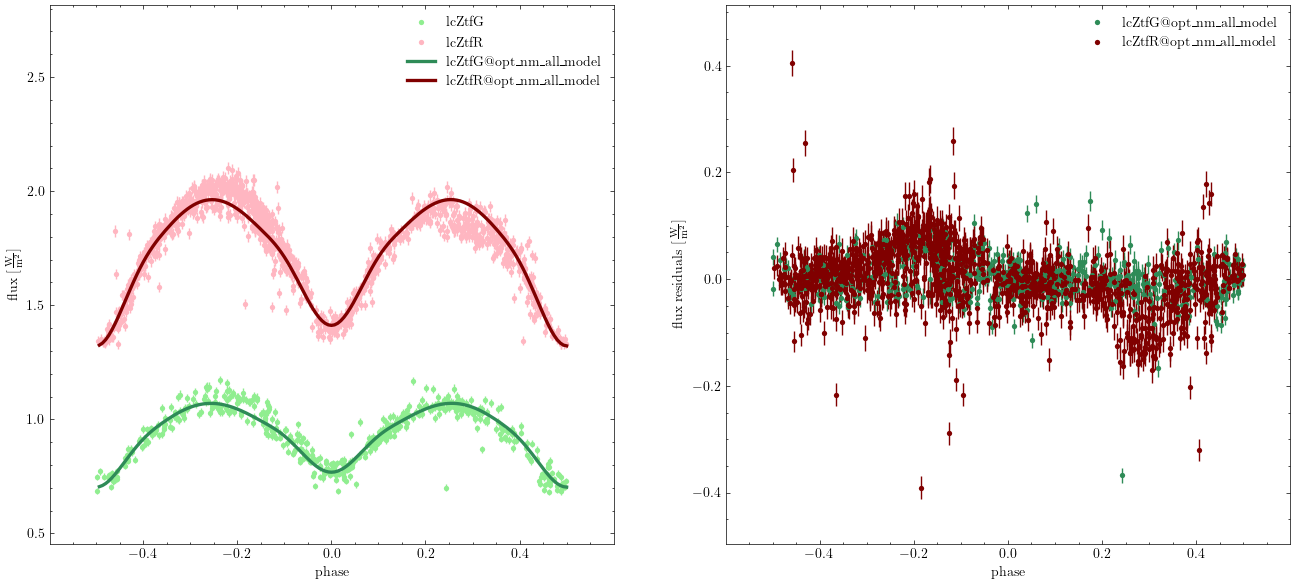

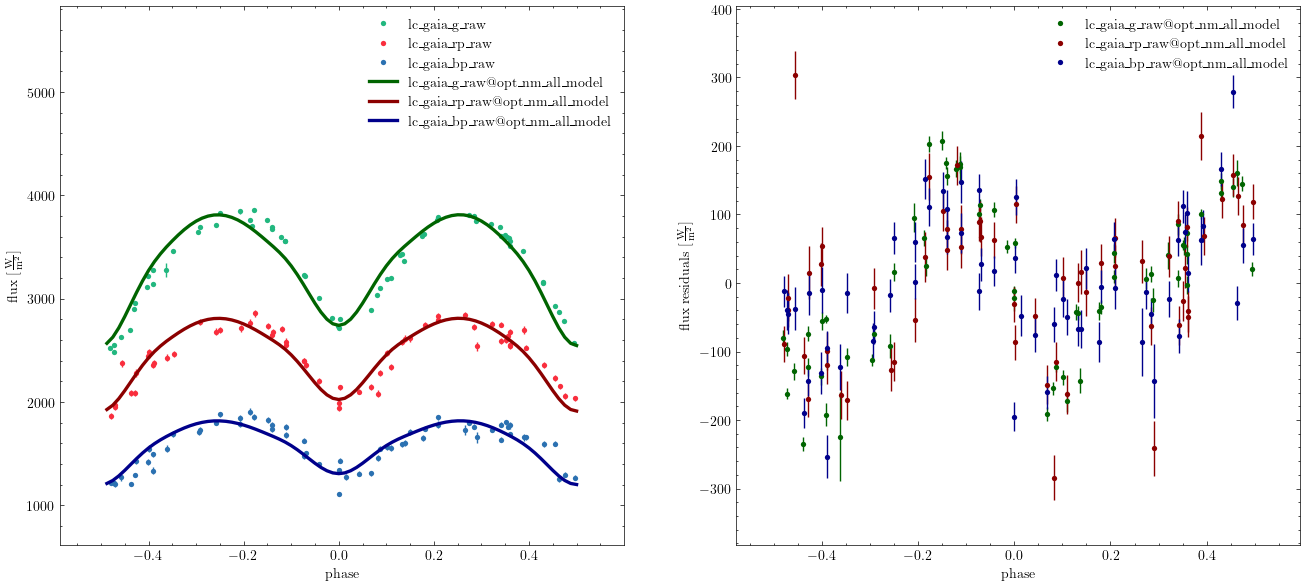

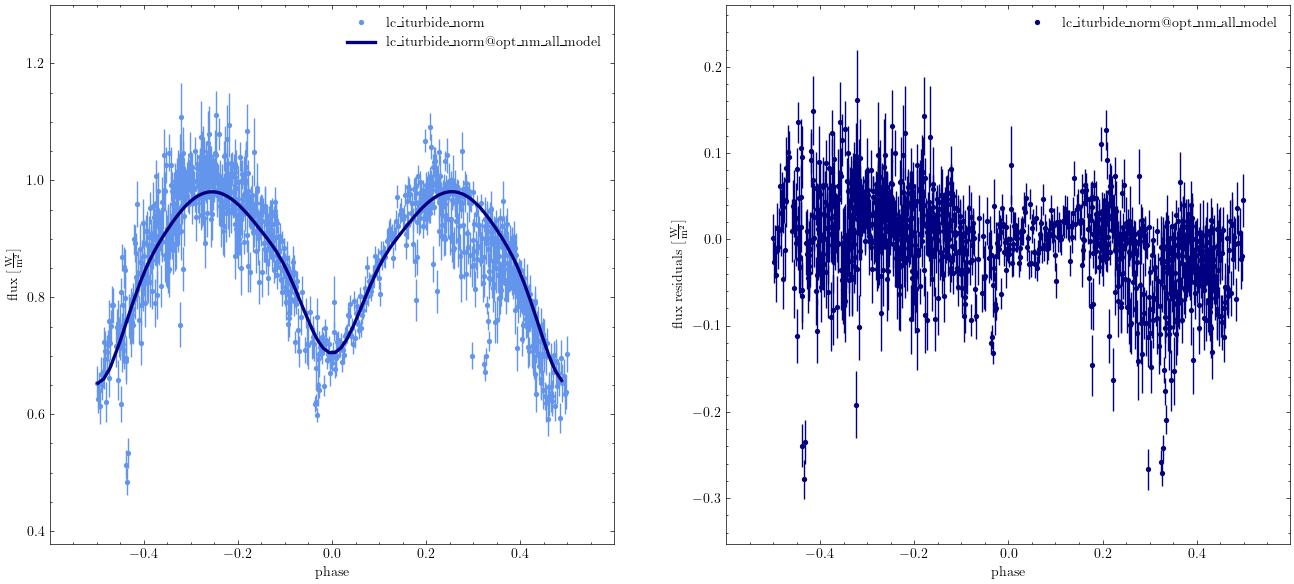

In [8]:
gen_utils.abilitateDatasets(b, ['lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/updated-data/results/opt_nm_all_solution", reset_params=False)

gen_utils.printAllModelsChi2(b)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(16, 7), datasetGroups=allDatasetPlotGroups, model=computeModelName)

# Sunspot Feature

Including a starspot to account for *O'Connell effect* seen in ZTF LCs.

In [9]:
b.flip_constraint(qualifier='compute_phases', dataset='mesh01', solve_for='compute_times')

<ConstraintParameter: {compute_times@mesh01@dataset} = phases_to_times({compute_phases@mesh01@dataset}, {phases_period@mesh01@dataset}, {period@binary@component}, {period_anom@binary@component}, {phases_dpdt@mesh01@dataset}, {dpdt@binary@component}, {phases_t0@mesh01@dataset}, {t0_supconj@binary@component}, {t0_perpass@binary@component}, {t0_ref@binary@component}) (solar units) => [ 0.          0.025       0.05        0.075       0.1         0.125
  0.15        0.175      -0.13356604 -0.10856604 -0.08356604 -0.05856604
 -0.03356604 -0.00856604  0.01643396  0.04143396  0.06643396  0.09143396
  0.11643396  0.14143396  0.16643396] d>

In [10]:
b.set_value(qualifier='compute_phases', dataset='mesh01', context='dataset', value=phoebe.linspace(-0.5, 0.5, 21))
print(b.get_value(qualifier='compute_phases', dataset='mesh01'))

[-0.5  -0.45 -0.4  -0.35 -0.3  -0.25 -0.2  -0.15 -0.1  -0.05  0.    0.05
  0.1   0.15  0.2   0.25  0.3   0.35  0.4   0.45  0.5 ]


In [11]:
gen_utils.abilitateDatasets(b, [])
b.run_compute(model='updated_mesh_phases', overwrite=True)

100%|██████████| 21/21 [00:04<00:00,  4.38it/s]


<ParameterSet: 213 parameters | components: primary, secondary>

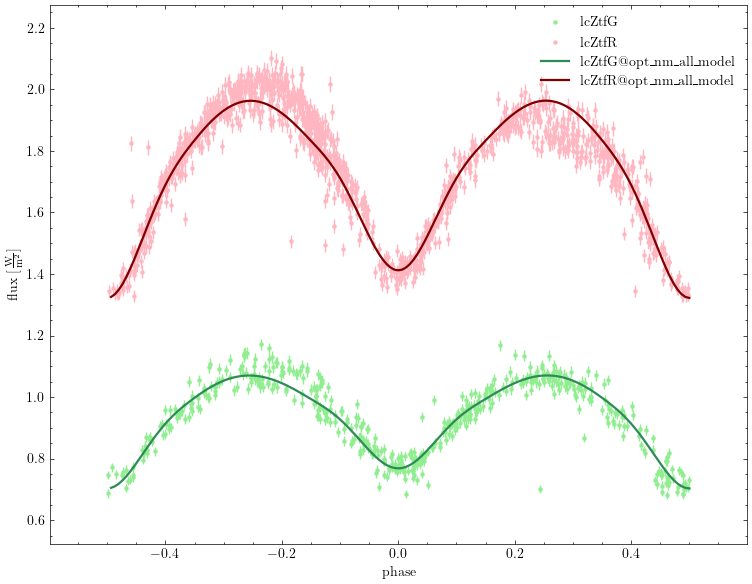

Mon, 18 Nov 2024 17:11 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.109282, assuming named color
Mon, 18 Nov 2024 17:11 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.109282, assuming named color


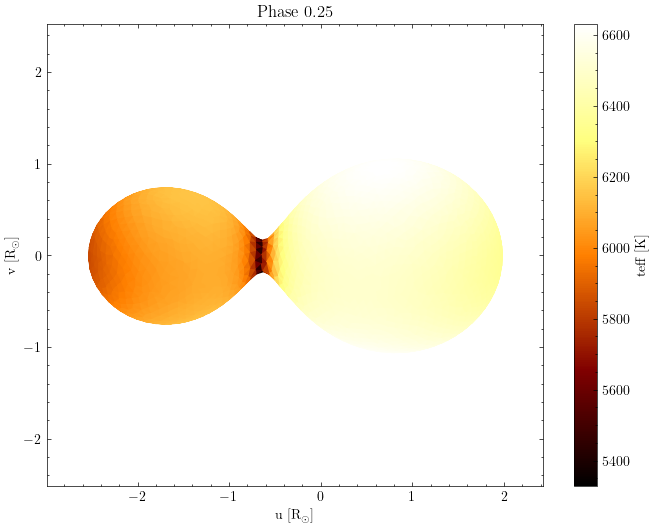

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 800x600 with 2 Axes>)

In [12]:
phase = 0.25
fig = plt.figure(figsize=(9, 7))
b.plot(x='phase', dataset=ztfDatasets, model='opt_nm_all_model', color=gen_utils.ZTF_PLOT_COLORS, marker={'dataset': '.'}, ls={'model': 'solid'}, fig=fig, legend=True, s=0.009, show=True)
b.plot(dataset='mesh01', kind='mesh', fc='teffs', ec='face', phase=phase, draw_sidebars=True, model='updated_mesh_phases', show=True, title=f"Phase {phase}", draw_title=True)

In [21]:
print(b['q'])

Parameter: q@binary@component
                       Qualifier: q
                     Description: Mass ratio
                           Value: 2.1347822302806985
                  Constrained by: 
                      Constrains: requiv@primary@component, requiv@secondary@component, pot@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, sma@binary@component, sma@primary@component, asini@primary@component, requiv_max@primary@component, requiv_min@primary@component, mass@secondary@component, sma@secondary@component, asini@secondary@component, requiv_max@secondary@component, requiv_min@secondary@component
                      Related to: pot@contact_envelope@component, sma@binary@component, requiv@primary@component, requiv@secondary@component, fillout_factor@contact_envelope@component, pot_min@contact_envelope@component, pot_max@contact_envelope@component, mass@primary@component, period@binary@component, sma@primary@component, incl@bina

## Primary hot spot

100%|██████████| 161/161 [00:35<00:00,  4.55it/s]
Wed, 23 Oct 2024 12:49 PARAMETERS   WARNING could not find Parameter match for ec=face at time=-0.057502, assuming named color
Wed, 23 Oct 2024 12:49 PARAMETERS   WARNING could not find Parameter match for ec=face at time=-0.057502, assuming named color


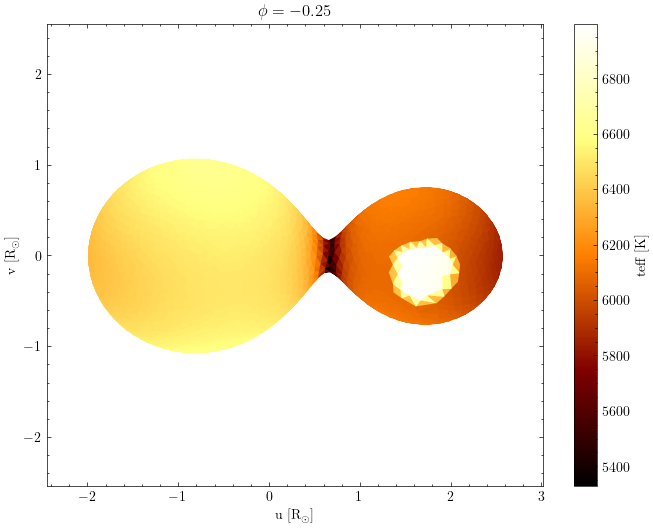

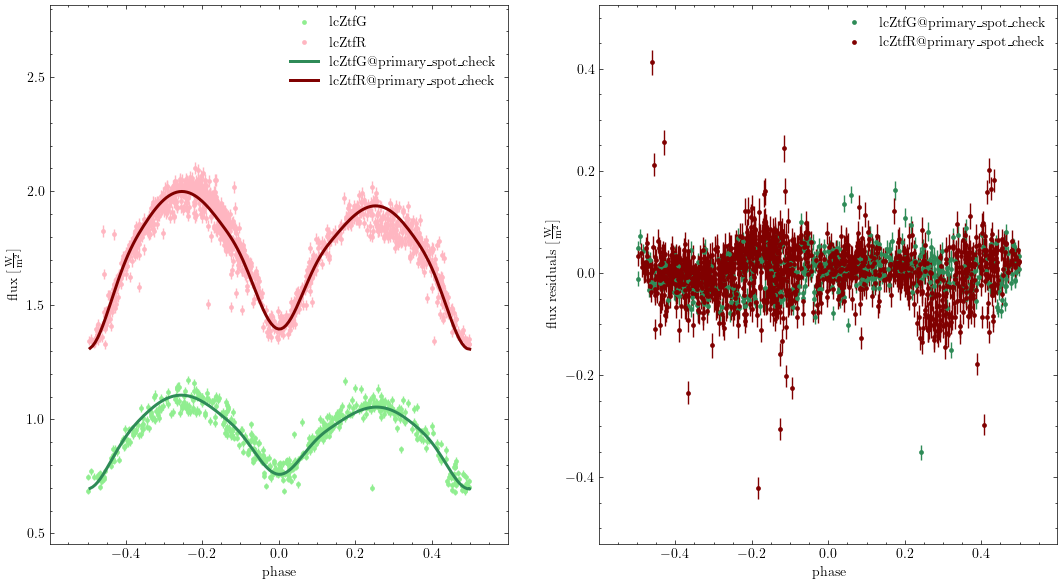

opt_nm_all_model
	 Gaia (Raw) - 8157.4133489297055
		 lc_gaia_g_raw - 6468.760107149583
		 lc_gaia_rp_raw - 796.3643574389818
		 lc_gaia_bp_raw - 892.2888843411414
------------------------------------------------
	 Iturbide (Norm) - 4936.775467748152
------------------------------------------------
	 ZTF - 11109.620823759094
		 lcZtfG - 3312.8171081171686
		 lcZtfR - 7796.803715641925
primary_spot_check
------------------------------------------------
------------------------------------------------
	 ZTF - 9827.431850373881
		 lcZtfG - 3316.686518378567
		 lcZtfR - 6510.745331995315


In [22]:
gen_utils.abilitateDatasets(b, ztfDatasets, includeMesh=True)

b.remove_features_all()
b.add_spot(component='primary', feature='primary_hot_spot')
b.set_value(qualifier='relteff', feature='primary_hot_spot', value=1.15)
b.set_value(qualifier='radius', feature='primary_hot_spot', value=25)
b.set_value(qualifier='colat', feature='primary_hot_spot', value=85)
b.set_value(qualifier='long', feature='primary_hot_spot', value=90)

b.run_compute(model='primary_spot_check', overwrite=True)
plotPhase = -0.25
b.plot(dataset='mesh01', phase=plotPhase, model='primary_spot_check', fc='teffs', ec='face', show=True, draw_sidebars=True, title=fr"$\phi = {plotPhase}$", draw_title=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[ztfDatasets], model='primary_spot_check')
gen_utils.printModelsChi2(b, ["opt_nm_all_model", "primary_spot_check"])

In [28]:
opt_utils.optimize_params(b, fit_twigs=['colat@primary_hot_spot', 'long@primary_hot_spot', 'radius@primary_hot_spot', 'relteff@primary_hot_spot'], 
						  label='primary_hot_spot', export=True, subfolder="updated-data", datasets=ztfDatasets, maxiter=250)

External Solver: ./external-jobs/updated-data/optimizer.nelder_mead_opt_primary_hot_spot.py ./results/opt_primary_hot_spot_solution


('opt_primary_hot_spot', 'opt_primary_hot_spot_solution')

In [24]:
b.models

['before_optimizers',
 'poro_sample',
 'opt_t0_model',
 'opt_nm_all_model',
 'updated_mesh_phases',
 'primary_spot_check']

Wed, 23 Oct 2024 14:35 BUNDLE       WARNING not all uniqueids in fitted_uniqueids@opt_primary_hot_spot_solution@solution are still valid.  Falling back on twigs.  Save and load same bundle to prevent this extra cost.


Adopted:
colat@primary_hot_spot@primary@spot@feature 92.48878 deg 
long@primary_hot_spot@primary@spot@feature 69.26108 deg 
radius@primary_hot_spot@primary@spot@feature 27.38493 deg 
relteff@primary_hot_spot@primary@spot@feature 1.11748  

Original values:
  colat@primary_hot_spot@primary@spot@feature 85.00000 deg 
  long@primary_hot_spot@primary@spot@feature 90.00000 deg 
  radius@primary_hot_spot@primary@spot@feature 25.00000 deg 
  relteff@primary_hot_spot@primary@spot@feature 1.15000 


100%|██████████| 161/161 [00:37<00:00,  4.33it/s]


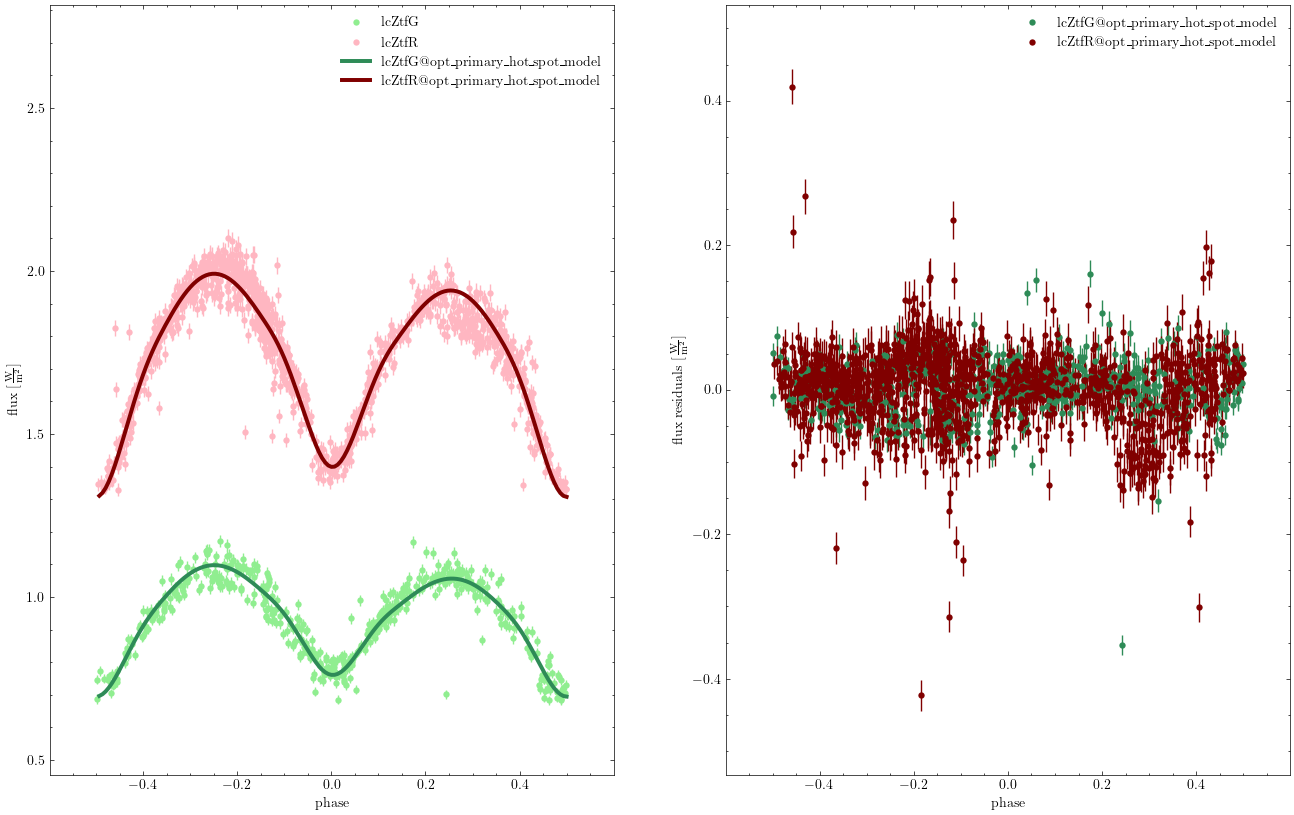

Wed, 23 Oct 2024 14:36 PARAMETERS   WARNING could not find Parameter match for ec=face at time=-0.057502, assuming named color
Wed, 23 Oct 2024 14:36 PARAMETERS   WARNING could not find Parameter match for ec=face at time=-0.057502, assuming named color


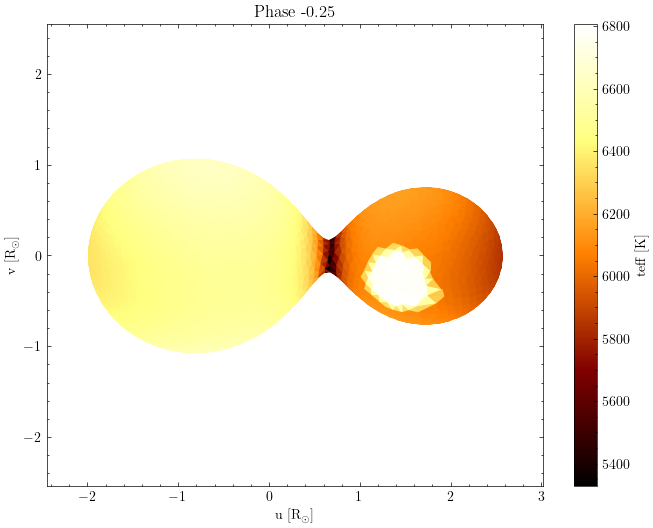

primary_spot_check
------------------------------------------------
------------------------------------------------
	 ZTF - 9827.431850373881
		 lcZtfG - 3316.686518378567
		 lcZtfR - 6510.745331995315
opt_primary_hot_spot_model
------------------------------------------------
------------------------------------------------
	 ZTF - 9691.385822854605
		 lcZtfG - 3181.2119093485985
		 lcZtfR - 6510.173913506006


In [25]:
gen_utils.abilitateDatasets(b, ztfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/updated-data/results/opt_primary_hot_spot_solution", reset_params=True)

phase = -0.25
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 10), datasetGroups=[ztfDatasets], model=computeModelName)
b.plot(dataset='mesh01', kind='mesh', fc='teffs', ec='face', phase=phase, draw_sidebars=True, model=computeModelName, show=True, title=f"Phase {phase}", draw_title=True)

gen_utils.printModelsChi2(b, ['primary_spot_check', computeModelName])

## Secondary Spot

100%|██████████| 161/161 [00:37<00:00,  4.28it/s]
Mon, 18 Nov 2024 17:11 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.109282, assuming named color
Mon, 18 Nov 2024 17:11 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.109282, assuming named color


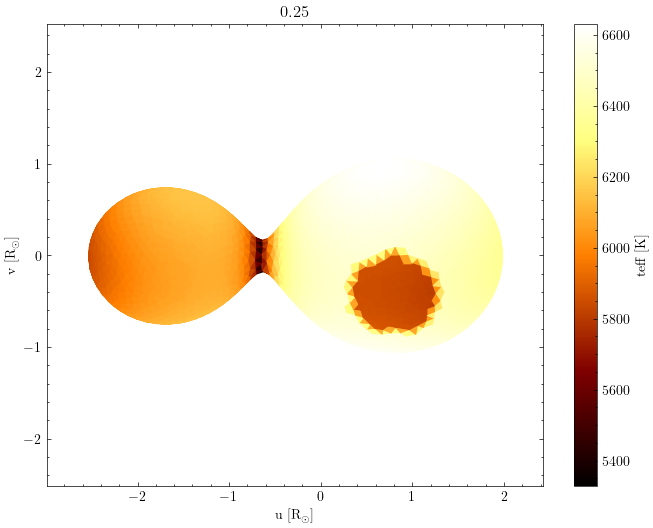

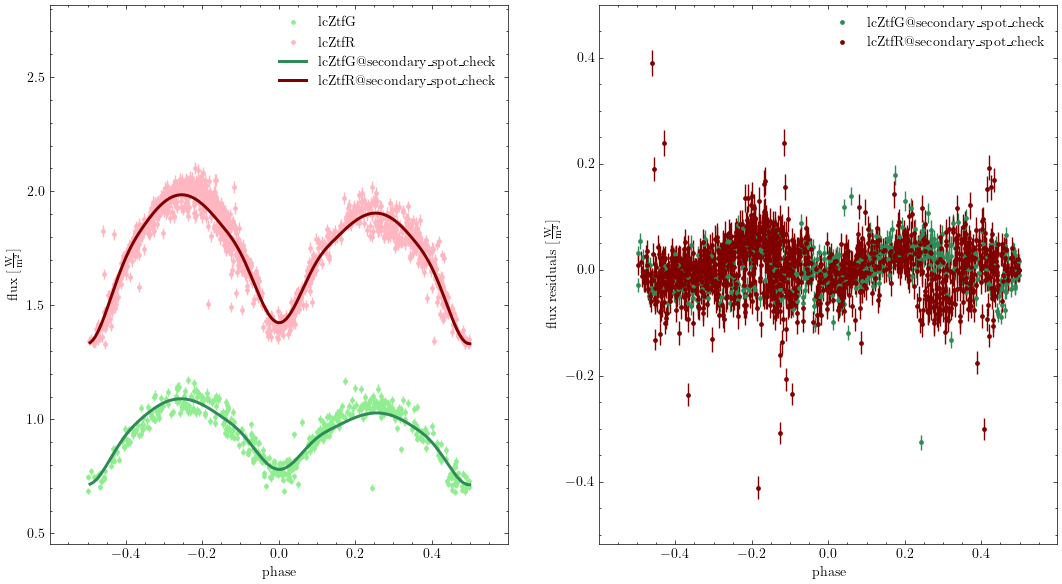

{'lcZtfG-lcZtfR': <Figure size 1300x700 with 2 Axes>}

In [13]:
# initial conditions for secondary spot; rough estimates based on light curve shape, giving the optimizer a starting point
gen_utils.abilitateDatasets(b, ztfDatasets, includeMesh=True)

b.remove_features_all()
b.add_spot(component='secondary', feature='secondary_spot', overwrite=True)
b.set_value(qualifier='relteff', feature='secondary_spot', value=0.9)
b.set_value(qualifier='radius', feature='secondary_spot', value=25)
b.set_value(qualifier='colat', feature='secondary_spot', value=85)
b.set_value(qualifier='long', feature='secondary_spot', value=90)

b.run_compute(model='secondary_spot_check', overwrite=True)

plotPhase = 0.25
b.plot(dataset='mesh01', phase=plotPhase, model='secondary_spot_check', fc='teffs', ec='face', show=True, draw_sidebars=True, title=str(plotPhase), draw_title=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[ztfDatasets], model='secondary_spot_check')

In [14]:
gen_utils.printAllModelsChi2(b)

before_optimizers
	 Gaia (Raw) - 13179.37983412342
		 lc_gaia_g_raw - 11176.209170988966
		 lc_gaia_rp_raw - 996.347378870178
		 lc_gaia_bp_raw - 1006.8232842642753
------------------------------------------------
	 Iturbide (Norm) - 5252.176551362905
------------------------------------------------
	 ZTF - 16150.653305378866
		 lcZtfG - 5249.853601990949
		 lcZtfR - 10900.799703387918
poro_sample
	 Gaia (Raw) - 13198.597691575877
		 lc_gaia_g_raw - 11194.141163808647
		 lc_gaia_rp_raw - 996.4022762096364
		 lc_gaia_bp_raw - 1008.0542515575937
------------------------------------------------
	 Iturbide (Norm) - 5255.932590890662
------------------------------------------------
	 ZTF - 16179.005351578428
		 lcZtfG - 5268.239816994614
		 lcZtfR - 10910.765534583814
opt_t0_model
	 Gaia (Raw) - 12793.741608174958
		 lc_gaia_g_raw - 10827.18224104041
		 lc_gaia_rp_raw - 976.8484147861956
		 lc_gaia_bp_raw - 989.7109523483518
------------------------------------------------
	 Iturbide (Norm)

In [142]:
opt_utils.optimize_params(b, fit_twigs=['colat@secondary_spot', 'long@secondary_spot', 'radius@secondary_spot', 'relteff@secondary_spot'], 
						  label='secondary_spot', export=True, subfolder="updated-data", datasets=ztfDatasets, maxiter=250)

External Solver: ./external-jobs/updated-data/optimizer.nelder_mead_opt_secondary_spot.py ./results/opt_secondary_spot_solution


('opt_secondary_spot', 'opt_secondary_spot_solution')

In [143]:
print(b['opt_secondary_spot_solution'])

ParameterSet: 0 parameters
NO PARAMETERS


In [15]:
gen_utils.abilitateDatasets(b, ztfDatasets)
# solutionName, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_secondary_spot_solution")
solutionName, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file="./external-jobs/updated-data/results/opt_secondary_spot_solution")

Mon, 18 Nov 2024 17:11 BUNDLE       WARNING not all uniqueids in fitted_uniqueids@opt_secondary_spot_solution@solution are still valid.  Falling back on twigs.  Save and load same bundle to prevent this extra cost.


Adopted:
colat@secondary_spot@secondary@spot@feature 89.77983 deg 
long@secondary_spot@secondary@spot@feature 81.09966 deg 
radius@secondary_spot@secondary@spot@feature 25.12086 deg 
relteff@secondary_spot@secondary@spot@feature 0.93007  

Original values:
  colat@secondary_spot@secondary@spot@feature 85.00000 deg 
  long@secondary_spot@secondary@spot@feature 90.00000 deg 
  radius@secondary_spot@secondary@spot@feature 25.00000 deg 
  relteff@secondary_spot@secondary@spot@feature 0.90000 


100%|██████████| 161/161 [00:37<00:00,  4.34it/s]


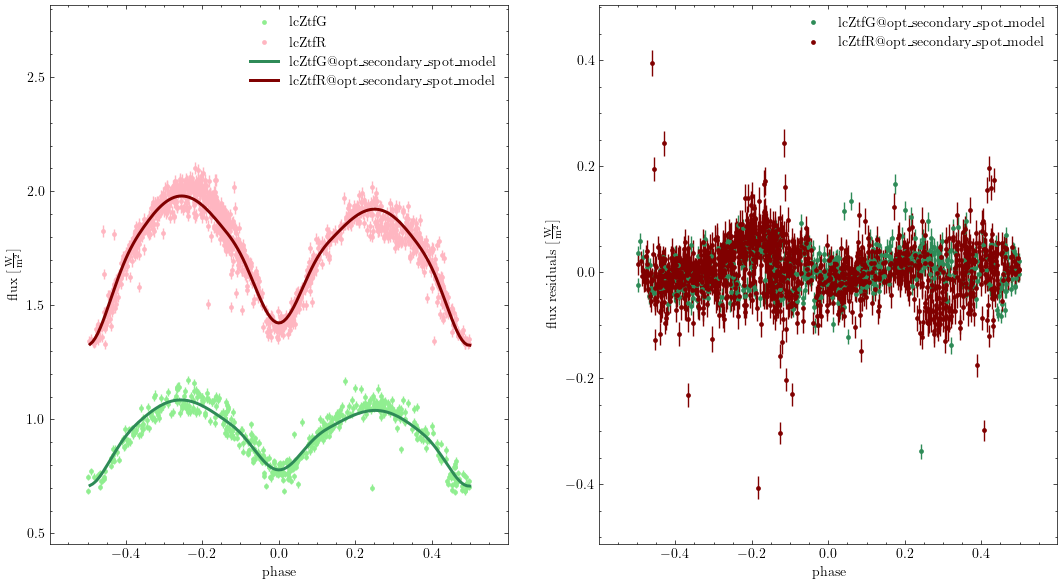

Mon, 18 Nov 2024 17:12 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.109282, assuming named color
Mon, 18 Nov 2024 17:12 PARAMETERS   WARNING could not find Parameter match for ec=face at time=00.109282, assuming named color


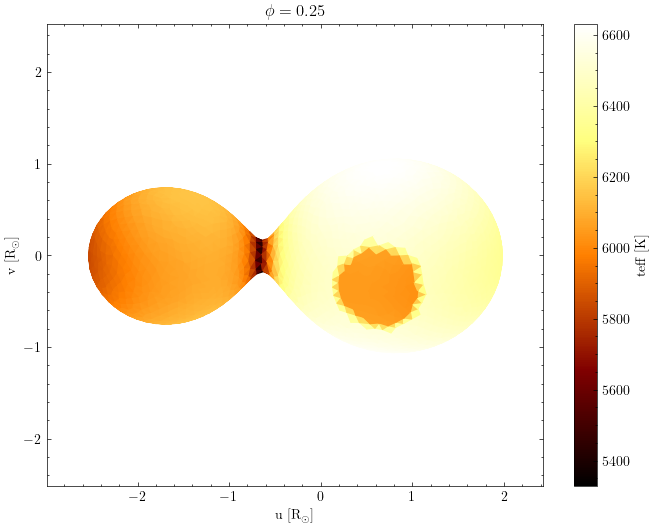

<Figure size 800x600 with 0 Axes>

In [16]:
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[ztfDatasets], model=computeModelName)
b.plot(dataset='mesh01', phase=plotPhase, model=computeModelName, fc='teffs', ec='face', show=True, draw_sidebars=True, title=fr"$\phi = {plotPhase}$", draw_title=True)
gen_utils.animateMesh(b, logger, model=computeModelName)

In [17]:
%%script echo "skipping; probably not needed"
gen_utils.abilitateDatasets(b, ztfDatasets)
# solutionName, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_secondary_spot_solution")
solutionName, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file="./external-jobs/updated-data/results/opt_secondary_spot_solution")
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

skipping; probably not needed


100%|██████████| 386/386 [01:29<00:00,  4.33it/s]


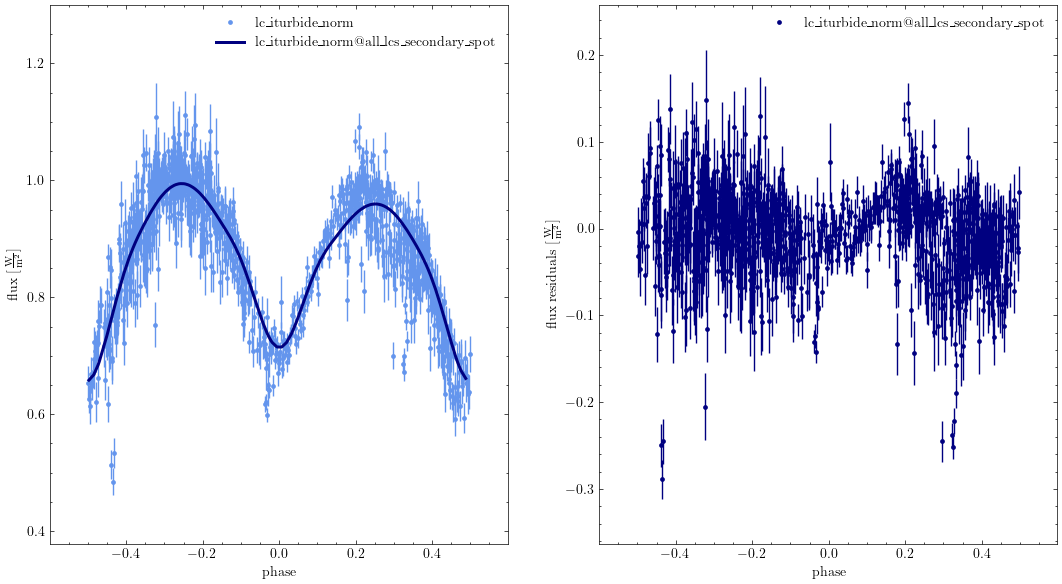

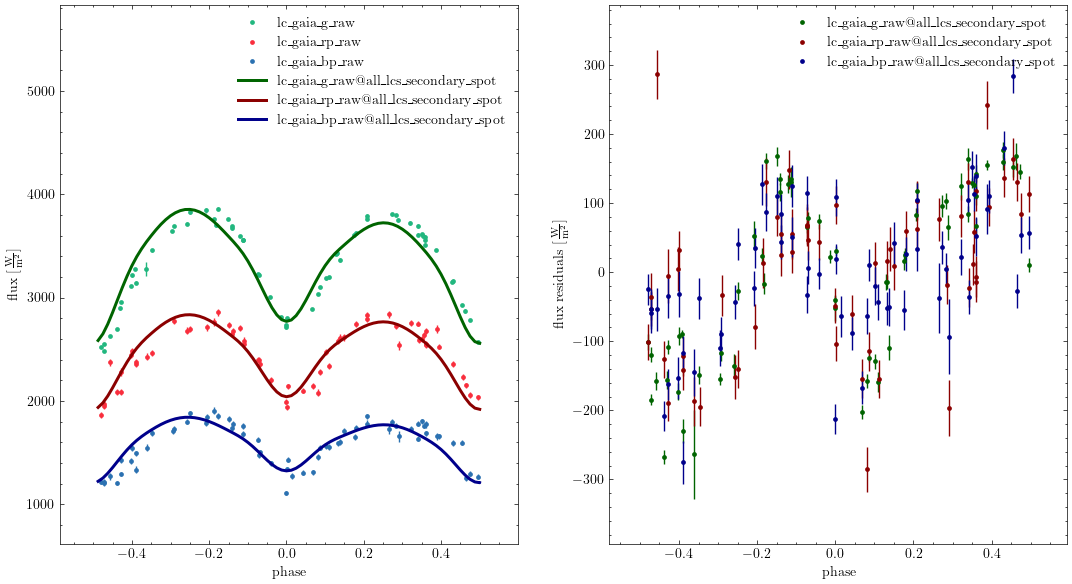

In [17]:
gen_utils.abilitateDatasets(b, rawGaiaDatasets + ['lc_iturbide_norm'] + ztfDatasets)
b.run_compute(model='all_lcs_secondary_spot', overwrite=True)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[['lc_iturbide_norm'], rawGaiaDatasets], model='all_lcs_secondary_spot')

In [18]:
b.set_value_all(qualifier='enabled', feature=b.features, value=False)
b.run_compute(model='opt_no_spot', overwrite=True)

100%|██████████| 386/386 [01:28<00:00,  4.38it/s]


<ParameterSet: 231 parameters | kinds: lc, mesh>

In [19]:
b.set_value_all(qualifier='enabled', feature=b.features, value=True)
gen_utils.printChi2(b, 'all_lcs_secondary_spot')
gen_utils.printChi2(b, 'opt_no_spot')

all_lcs_secondary_spot
	 Gaia (Raw) - 9943.450966397466
		 lc_gaia_g_raw - 8080.650986531044
		 lc_gaia_rp_raw - 862.7158079069018
		 lc_gaia_bp_raw - 1000.0841719595217
------------------------------------------------
	 Iturbide (Norm) - 4629.917998115723
------------------------------------------------
	 ZTF - 9766.87925683606
		 lcZtfG - 3295.714468677499
		 lcZtfR - 6471.164788158561
opt_no_spot
	 Gaia (Raw) - 8157.318753241743
		 lc_gaia_g_raw - 6468.665475477754
		 lc_gaia_rp_raw - 796.361735990571
		 lc_gaia_bp_raw - 892.2915417734183
------------------------------------------------
	 Iturbide (Norm) - 4937.159770359331
------------------------------------------------
	 ZTF - 11109.883758507087
		 lcZtfG - 3312.83404695577
		 lcZtfR - 7797.049711551316


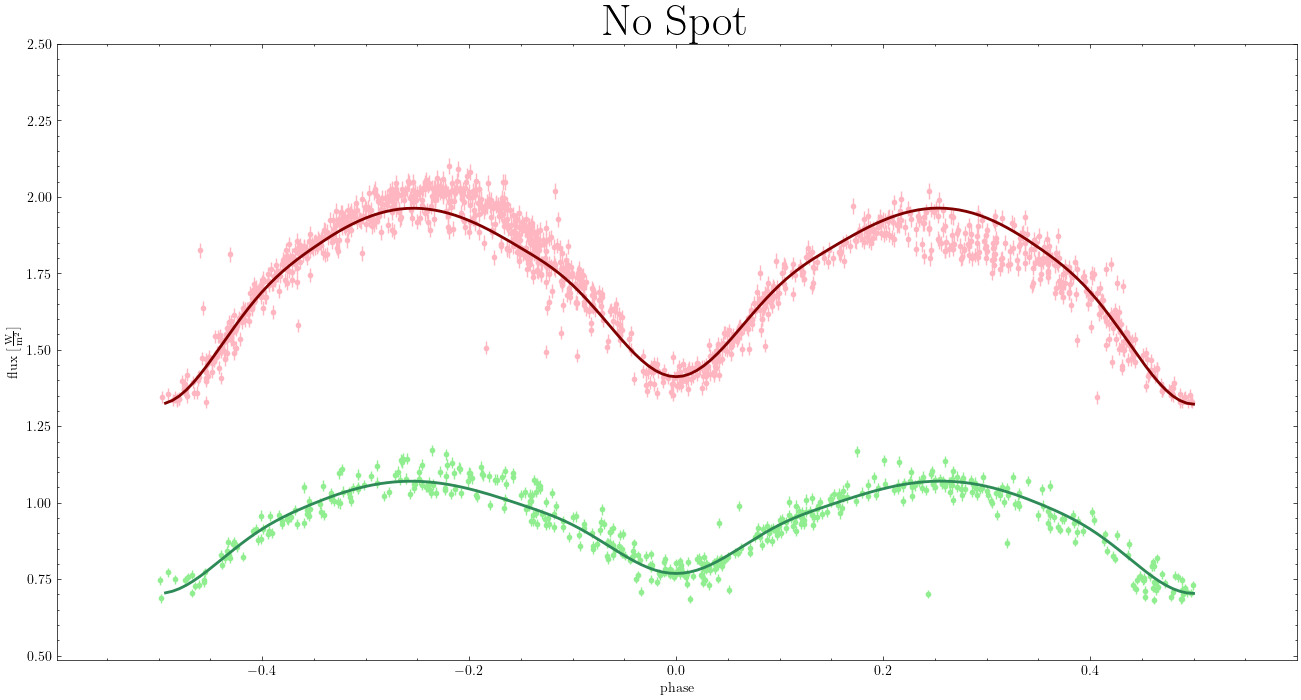

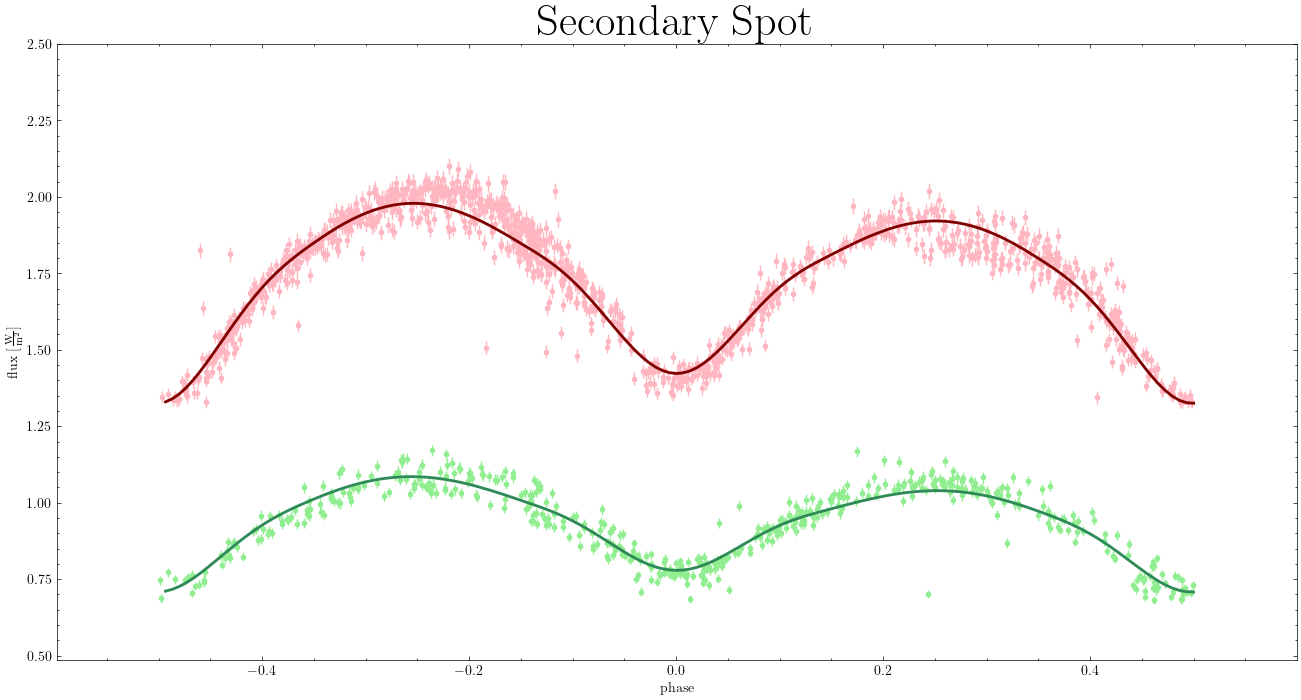

In [35]:
originalTitleSize = plt.rcParams['axes.titlesize']
plt.rcParams['axes.titlesize'] = 32

b.plot(x='phase', show=True, model='opt_no_spot', dataset=ztfDatasets, s=0.008, marker={'dataset': '.'}, ls={'model': 'solid'}, c=gen_utils.ZTF_PLOT_COLORS, fig=plt.figure(figsize=(16, 8)), draw_title=True, title='No Spot', ylim=(None, 2.5))
b.plot(x='phase', show=True, model='all_lcs_secondary_spot', dataset=ztfDatasets, s=0.008, marker={'dataset': '.'}, ls={'model': 'solid'}, c=gen_utils.ZTF_PLOT_COLORS, fig=plt.figure(figsize=(16, 8)), draw_title=True, title='Secondary Spot', ylim=(None, 2.5))

plt.rcParams['axes.titlesize'] = originalTitleSize

# Differential Optimization Adjustments

Parameter optimization through differential techniques to get closer to parameter space minimum. Trying out both `differential_evolution` and `differential_correction` optimizers, of which DE optimizer will run on remote server to take advantage of the greater amount of threads available for heavy usage.

Opted for executing DC optimizer in notebook directly, since `differential_correction` is single-threaded and therefore benefits most from single core speed. Current servers have ancient CPUs, which, while having an enormous amount of threads to work with, are painfully slow for single-threaded tasks.

In [149]:
# original values

print(b['teffratio'])
print(b['incl@binary'])
print(b['fillout_factor'])

Parameter: teffratio@binary@component
                       Qualifier: teffratio
                     Description: ratio between effective temperatures of children stars
                           Value: 1.0799145032852362
                  Constrained by: 
                      Constrains: teff@secondary@component
                      Related to: teff@primary@component, teff@secondary@component

Parameter: incl@binary@component
                       Qualifier: incl
                     Description: Orbital inclination angle
                           Value: 70.19809817084013 deg
                  Constrained by: 
                      Constrains: asini@binary@component, asini@primary@component, incl@primary@component, asini@secondary@component, incl@secondary@component
                      Related to: sma@binary@component, asini@binary@component, q@binary@component, asini@primary@component, pitch@primary@component, incl@primary@component, asini@secondary@component, pitch@secondary

## Differential Corrections

In [27]:
beforeDcBackup = b.copy()

In [28]:
gen_utils.abilitateDatasets(b, ztfDatasets, False)
b.add_solver('optimizer.differential_corrections', solver='dc_relative', overwrite=True,
             fit_parameters=['teffratio', 'incl@binary', 'fillout_factor', 'q'],
             steps={
                'q': 0.01,
                'incl@binary': 1,
                'fillout_factor': 0.01,
                'teffratio': 0.01
             })
b.remove_models_all()
gen_utils.saveBundle(b, bundleName="dc-start-primary-hot-spot", subfolder="updated-data/dc-opt")
b = beforeDcBackup.copy()

Wed, 23 Oct 2024 14:39 PARAMETERS   WARNING for faster compact saving, install ujson


In [33]:
primarySpotSolution = b.filter(solution='opt_primary_hot_spot_solution')
print(primarySpotSolution.get_value(qualifier='fitted_twigs'))

['colat@primary_hot_spot@primary@spot@feature'
 'long@primary_hot_spot@primary@spot@feature'
 'radius@primary_hot_spot@primary@spot@feature'
 'relteff@primary_hot_spot@primary@spot@feature']


In [29]:
b.solutions

['ebai_knn_all_solution',
 'ebai_knn_ztf_gaia_solution',
 'ebai_knn_iturbide_solution',
 'ebai_knn_iturbide_ztf_solution',
 'ebai_knn_ztf_solution',
 'ebai_knn_raw_gaia_solution',
 'opt_nm_all_solution',
 'opt_primary_hot_spot_solution']

In [152]:
# best results after 1 iteration
# dcFitVals = {
#     "teffratio@binary@orbit@component": 1.05923,
#     "incl@binary@orbit@component": 69.65312*u.deg,
#     "fillout_factor@contact_envelope@envelope@component": 0.11717,
#     "q@binary@orbit@component": 1.81910
# }

# technically best result after 17 iterations, but much different values for q
dcFitVals = {
    "teffratio@binary@orbit@component": 1.06676,
    "incl@binary@orbit@component": 68.42157*u.deg,
    "fillout_factor@contact_envelope@envelope@component": 0.07892,
    "q@binary@orbit@component": 1.10457
}

for twig, val in dcFitVals.items():
    b.set_value(twig, value=val)

b.set_value_all(qualifier='enabled', value=True)
b.run_compute(model='dc_best_solution_model', overwrite=True)

Sat, 03 Aug 2024 09:34 BUNDLE       ERROR   Constraint 'requiv@primary@star@constraint' raised the following error while attempting to solve for 'requiv@primary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@primary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
Sat, 03 Aug 2024 09:34 BUNDLE       ERROR   Constraint 'requiv@secondary@star@constraint' raised the following error while attempting to solve for 'requiv@secondary@star@component'.  Consider flipping the constraint or changing the value of one of ['pot@contact_envelope@envelope@component', 'q@binary@orbit@component', 'sma@binary@orbit@component', 'requiv@secondary@star@component'] until the constraint succeeds.  Original error: potential > L1 critical value
100%|██████████| 386/386 [01:34<00:00,  4.08it/s]


<ParameterSet: 231 parameters | kinds: lc, mesh>

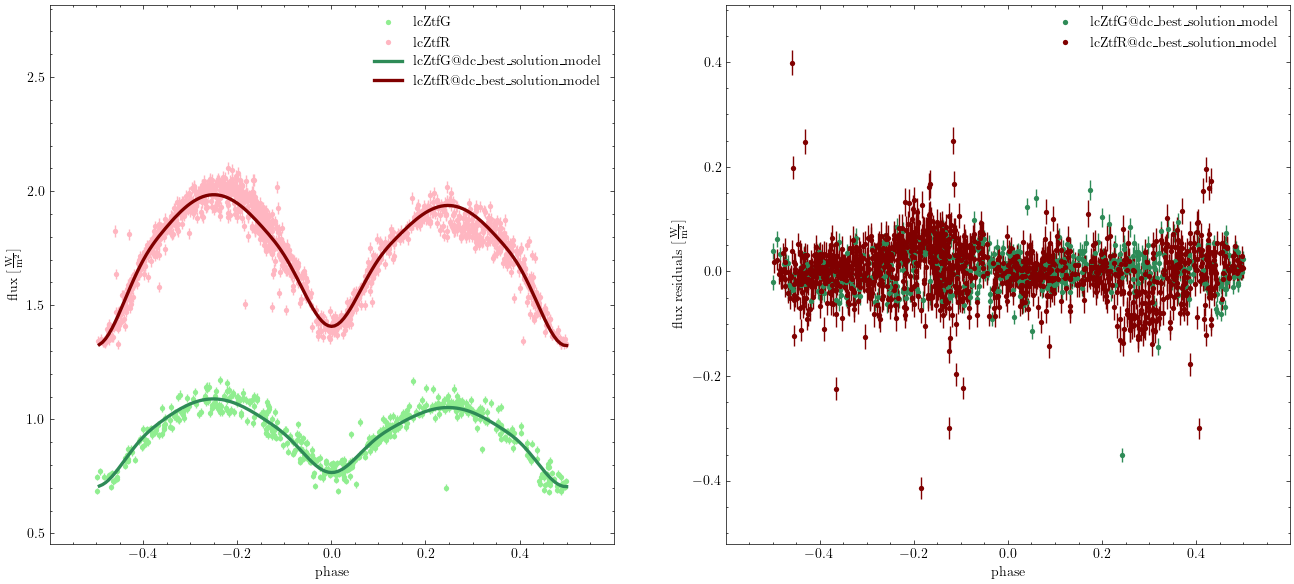

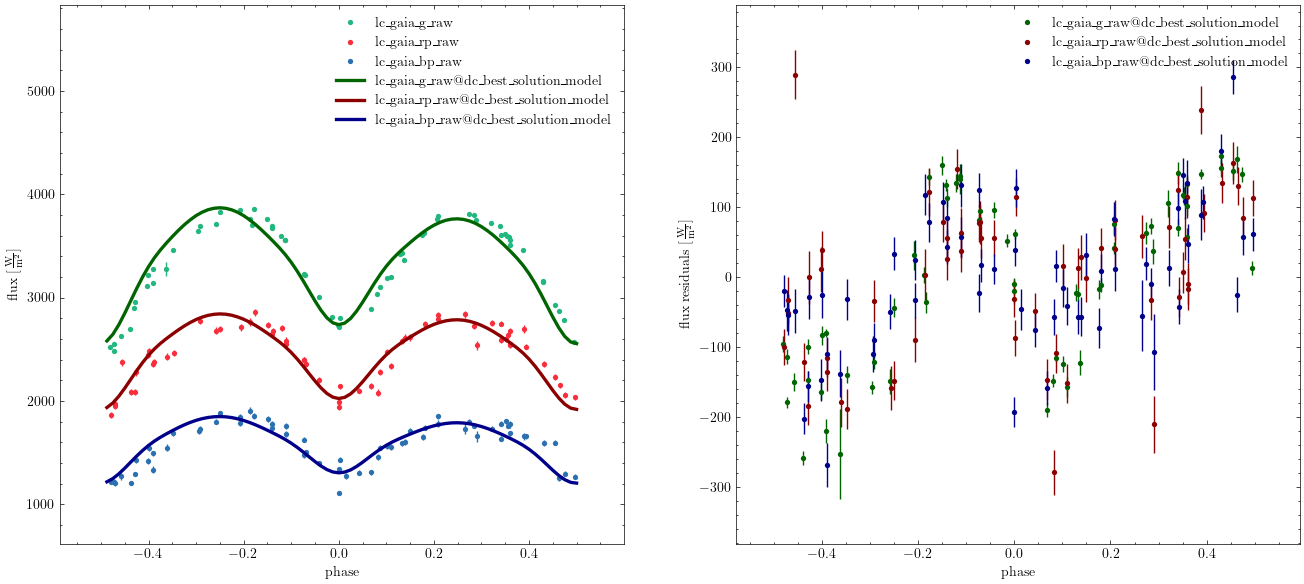

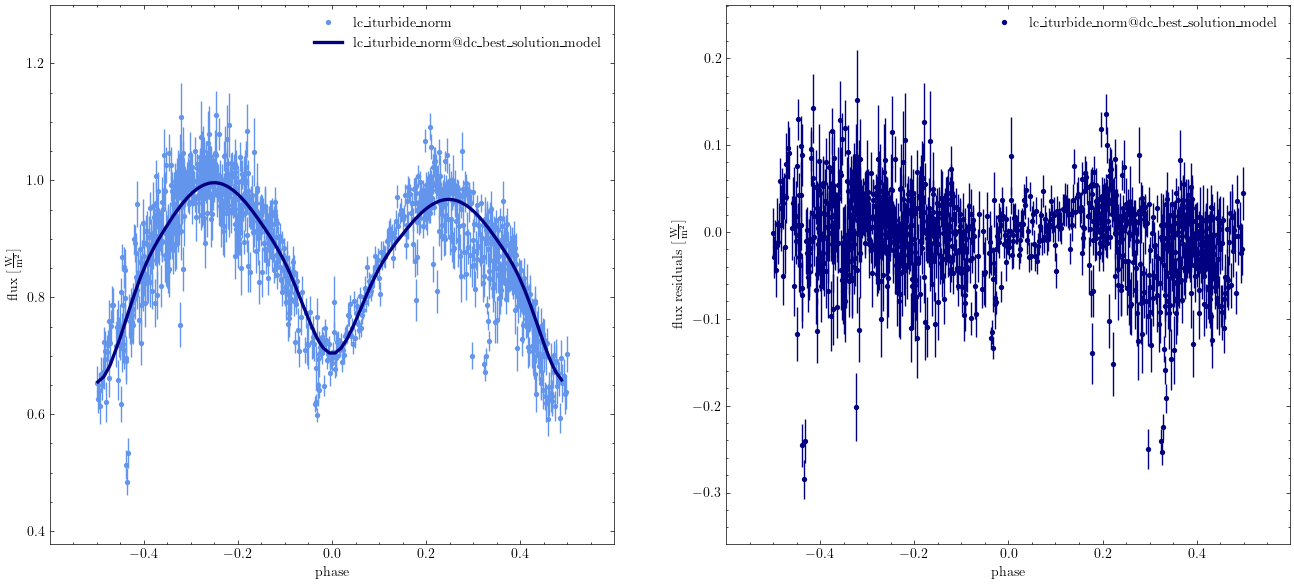

{'lcZtfG-lcZtfR': <Figure size 1600x700 with 2 Axes>,
 'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1600x700 with 2 Axes>,
 'lc_iturbide_norm': <Figure size 1600x700 with 2 Axes>}

In [153]:
gen_utils.plotModelResidualsFigsize(b, figsize=(16, 7), datasetGroups=allDatasetPlotGroups, model='dc_best_solution_model')

In [154]:
gen_utils.printAllModelsChi2(b)

before_optimizers
	 Gaia (Raw) - 13179.391625955395
		 lc_gaia_g_raw - 11176.21383724974
		 lc_gaia_rp_raw - 996.3525261709403
		 lc_gaia_bp_raw - 1006.8252625347158
------------------------------------------------
	 Iturbide (Norm) - 5254.494483017592
------------------------------------------------
	 ZTF - 16143.529065239905
		 lcZtfG - 5244.7217304115175
		 lcZtfR - 10898.807334828387
poro_sample
	 Gaia (Raw) - 13198.730458784532
		 lc_gaia_g_raw - 11194.257842692314
		 lc_gaia_rp_raw - 996.4099934724072
		 lc_gaia_bp_raw - 1008.0626226198111
------------------------------------------------
	 Iturbide (Norm) - 5258.324832963756
------------------------------------------------
	 ZTF - 16171.886887637465
		 lcZtfG - 5263.060886486252
		 lcZtfR - 10908.826001151214
opt_t0_model
	 Gaia (Raw) - 12793.877039457688
		 lc_gaia_g_raw - 10827.301256273857
		 lc_gaia_rp_raw - 976.8565376779175
		 lc_gaia_bp_raw - 989.7192455059132
------------------------------------------------
	 Iturbide (No

In [155]:
gen_utils.animateMesh(b, logger, model='dc_best_solution_model')

<Figure size 800x600 with 0 Axes>

# Adjusting Component $T_{eff}$

Since these parameters are some of the last that will likely need to be adjusted for this model, here we try adjusting the component $T_{eff}$ using the color
difference from each set of light curves. The optimized temperatures will need to agree with Gaia and ZTF data, since this is where we have color information.

Will run 3 separate optimizers; one including normalized datasets only (+ZTF), one including raw datasets only (-ZTF), and one with raw datasets + ZTF normalized.

In [156]:
pb_backup = b.copy()

In [109]:
%%script echo "skip unless need to restore from backup"
b = pb_backup.copy()

skip unless need to restore from backup


In [157]:
# coupling Gaia color LCs to Gaia_G
b.set_value_all(qualifier='pblum_mode', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='dataset-coupled')
b.set_value_all(qualifier='pblum_dataset', dataset=['lc_gaia_rp_raw', 'lc_gaia_bp_raw'], value='lc_gaia_g_raw')

# coupling ZTF color to ZTF_G
b.set_value(qualifier='pblum_mode', dataset='lcZtfG', value='component-coupled')
b.set_value(qualifier='pblum_mode', dataset='lcZtfR', value='dataset-coupled')
b.set_value(qualifier='pblum_dataset', dataset='lcZtfR', value='lcZtfG')

100%|██████████| 221/221 [00:56<00:00,  3.92it/s]


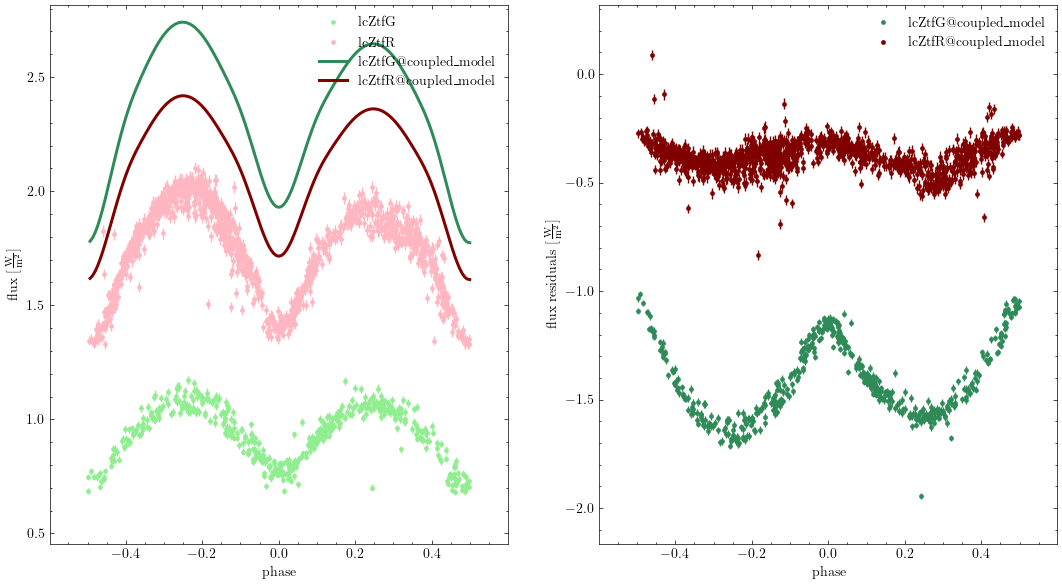

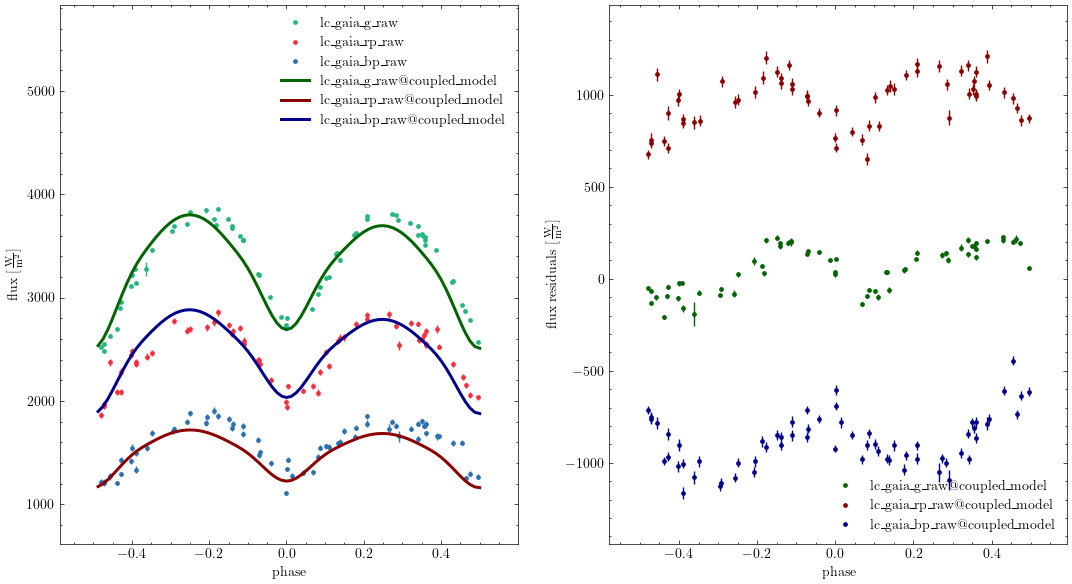

{'lcZtfG-lcZtfR': <Figure size 1300x700 with 2 Axes>,
 'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1300x700 with 2 Axes>}

In [158]:
# b.set_value(qualifier='teff', component='primary', context='component', value=4600*u.K)
gen_utils.abilitateDatasets(b, ztfDatasets + rawGaiaDatasets)
b.run_compute(model='coupled_model', overwrite=True)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[ztfDatasets, rawGaiaDatasets], model='coupled_model')

## Original Adjustment

Coupled all Gaia LCs together; **results in bad temperature adjustment**

In [112]:
%%script echo "skipping for following optimizer instead"
# normalized datasets; excluding Aviles norm (since it's a very sparse dataset)
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_norm", export=True, subfolder="iturbide-gaia-ztf-relative_norm", overwrite_export=False,
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_norm', 'pblum@primary@lcZtfG', 'pblum@primary@lc_iturbide_norm'],
						  datasets=normGaiaDatasets + ztfDatasets + ['lc_iturbide_norm'], maxiter=500)

skipping for following optimizer instead


In [113]:
%%script echo "skipping for following optimizer instead"
solutionName, computeModelName = opt_utils.adopt_solution(b, 
													solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_teff_ff_pblum_iturbide_gaia_ztf_norm_solution", 
													reset_params=True, dataset=['mesh01', 'lc_iturbide_norm'] + normGaiaDatasets + ztfDatasets)
gen_utils.plotModelResidualsFigsize(b, figsize=(17, 8), datasetGroups=[['lc_iturbide_norm'], normGaiaDatasets, ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

skipping for following optimizer instead


In [114]:
%%script echo "skipping for following optimizer instead"
# raw datasets only
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw'],
						  datasets=rawGaiaDatasets + ['lc_iturbide_raw'], maxiter=500)

skipping for following optimizer instead


In [115]:
%%script echo "skipping for following optimizer instead"
# raw + ZTF
opt_utils.optimize_params(b, label="teff_ff_pblum_iturbide_gaia_ztf_raw", export=True, subfolder="iturbide-gaia-ztf-ltt", 
						  fit_twigs=['teffratio', 'fillout_factor', 'teff@primary', 'pblum@primary@lc_gaia_g_raw', 'pblum@primary@lc_iturbide_raw', 'pblum@primary@lcZtfG'],
						  datasets=rawGaiaDatasets + ztfDatasets + ['lc_iturbide_raw'], maxiter=500)

skipping for following optimizer instead


## Adjusting Sets of Colors

3 different optimizers to determine component $T_{eff}$: using only Gaia color ($G - RP$ and $G - BP$), using only ZTF color ($G - R$), and one using both sets of light curves.

Only adjusting `teffratio`, `teff@primary`, and `pblum`; adjusting radii using `fillout_factor` should probably be done before changing passband scaling.

In [159]:
# ztf only
opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary', 'pblum@primary@lcZtfG'], label='ztf_teff', export=True,overwrite_export=True,
						  datasets=ztfDatasets, subfolder='updated-data', maxiter=500)

# gaia + ztf; removed since Gaia is very affected by interstellar extinction
# opt_utils.optimize_params(b, fit_twigs=['teffratio', 'teff@primary'], label='gaia_g_ztf_teff', export=True, overwrite_export=True,
# 						  datasets=rawGaiaDatasets + trimmedZtfDatasets, subfolder='iturbide-gaia-ztf-relative_norm', maxiter=500)

External Solver: ./external-jobs/updated-data/optimizer.nelder_mead_opt_ztf_teff.py ./results/opt_ztf_teff_solution


('opt_ztf_teff', 'opt_ztf_teff_solution')

In [117]:
%%script echo "skipping; not optimizing gaia datasets"

# gaia + ztf
gen_utils.abilitateDatasets(b, rawGaiaDatasets + ztfDatasets)
solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/iturbide-gaia-ztf-relative_norm/results/opt_gaia_g_ztf_teff_solution", reset_params=True)
gen_utils.printChi2(b, computeModelName)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[rawGaiaDatasets, ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName)

skipping; not optimizing gaia datasets


Adopted:
teffratio@binary@orbit@component 1.05213  
teff@primary@star@component 4203.69115 K 
pblum@primary@lcZtfG@lc@dataset 4.78643 W 

Original values:
  teffratio@binary@orbit@component 1.06676 
  teff@primary@star@component 6000.00000 K 
  pblum@primary@lcZtfG@lc@dataset 12.56637 W 


100%|██████████| 221/221 [00:54<00:00,  4.03it/s]


ParameterSet: 11 parameters
R  fitted_twigs@opt_ztf_teff@o...: ['teffratio@binary@orbit@component' 'teff@primary@star@component'
 'pblum@primary@lcZtfG@lc@dataset']
   adopt_parameters@opt_ztf_te...: ['teffratio@binary@orbit@component', 'teff@primary@star@component', 'pblum@primary@lcZtfG@lc@dataset']
   adopt_distributions@opt_ztf...: False
   adopt_values@opt_ztf_teff@o...: True
R  message@opt_ztf_teff@opt_zt...: Optimization terminated successfully.
R  niter@opt_ztf_teff@opt_ztf_...: 174
R  success@opt_ztf_teff@opt_zt...: True
R  initial_values@opt_ztf_teff...: [1.06676 6000.0 12.566370614359172]
R  fitted_values@opt_ztf_teff@...: [1.0521319006279142 4203.691151764369 4.786429344627436]
R  fitted_units@opt_ztf_teff@o...: ['' 'K' 'W']
   comments@opt_ztf_teff@opt_z...: 
opt_ztf_teff_model
	 Gaia (Raw) - 16420.114838666603
		 lc_gaia_g_raw - 8017.037094959718
		 lc_gaia_rp_raw - 2996.7688572666243
		 lc_gaia_bp_raw - 5406.308886440262
------------------------------------------------
-

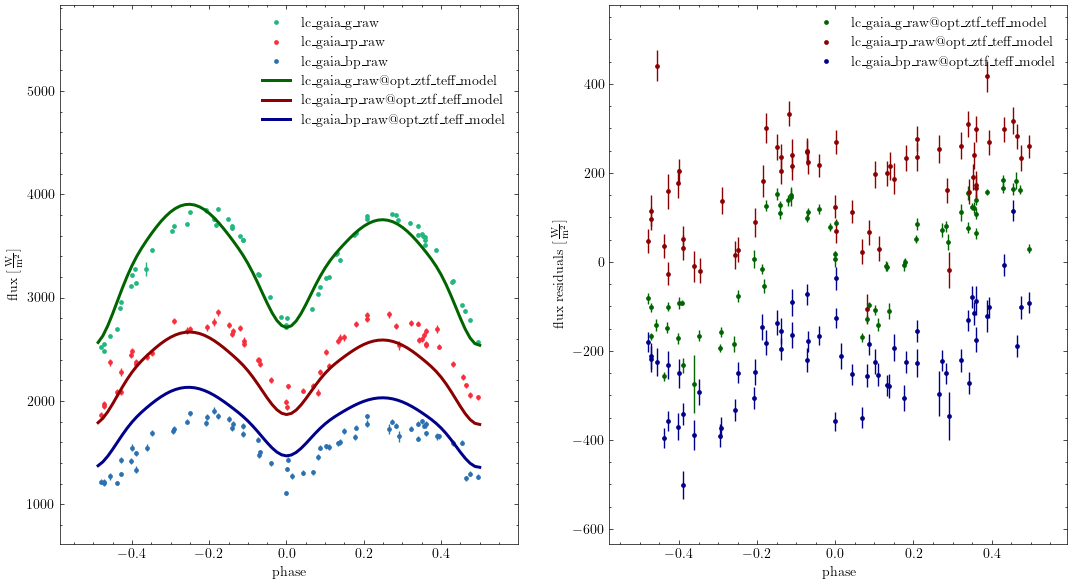

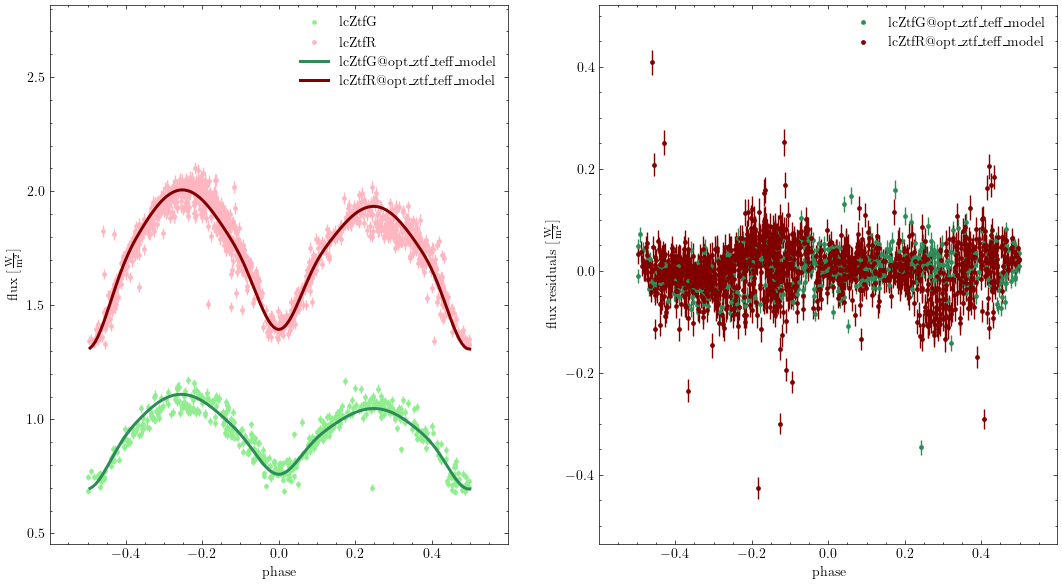

<Figure size 800x600 with 0 Axes>

In [160]:
# ztf only; gaia seems to be affected by ISM extinction
gen_utils.abilitateDatasets(b, rawGaiaDatasets + ztfDatasets)

solutionName, computeModelName = opt_utils.adopt_solution(b, solution_file="./external-jobs/updated-data/results/opt_ztf_teff_solution", reset_params=False)
print(b['teff@secondary'])
print(b['opt_ztf_teff_solution'])
gen_utils.printChi2(b, computeModelName)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[rawGaiaDatasets, ztfDatasets], model=computeModelName)
gen_utils.animateMesh(b, logger, model=computeModelName, color='inferno')

## Iturbide

In [ ]:
%%script echo "skipping; won't be using this light curve for sampling"

# norm full
solutionPath = gen_solution_path('iturbide_norm_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lc_iturbide_norm@dataset'], label='iturbide_norm_pblum', export=False, datasets=['lc_iturbide_norm'], maxiter=40)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=['lc_iturbide_norm'], model=computeModelName)

skipping; keeping dataset-scaled for main datasets, avoiding adjusting for passband luminosity


In [ ]:
%%script echo "skipping; won't be using this light curve for sampling"

# norm Aviles
solutionPath = gen_solution_path('iturbide_aviles_norm_pblum_local')
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lc_iturbide_aviles_norm@dataset'], label='iturbide_aviles_norm_pblum', export=False, 
											 	datasets=['lc_iturbide_aviles_norm'], maxiter=40)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
_ = gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=['lc_iturbide_aviles_norm'], model=computeModelName)

skipping; keeping dataset-scaled for main datasets, avoiding adjusting for passband luminosity


## Gaia

In [ ]:
b.set_value(qualifier='pblum_mode', dataset='lc_gaia_g_raw', value='component-coupled')

100%|██████████| 40/40 [23:46<00:00, 35.67s/it]


Adopted:
pblum@primary@lc_gaia_g_raw@lc@dataset 13823.37031 W 

Original values:
  pblum@primary@lc_gaia_g_raw@lc@dataset 12.56637 W 


100%|██████████| 81/81 [00:20<00:00,  4.02it/s]


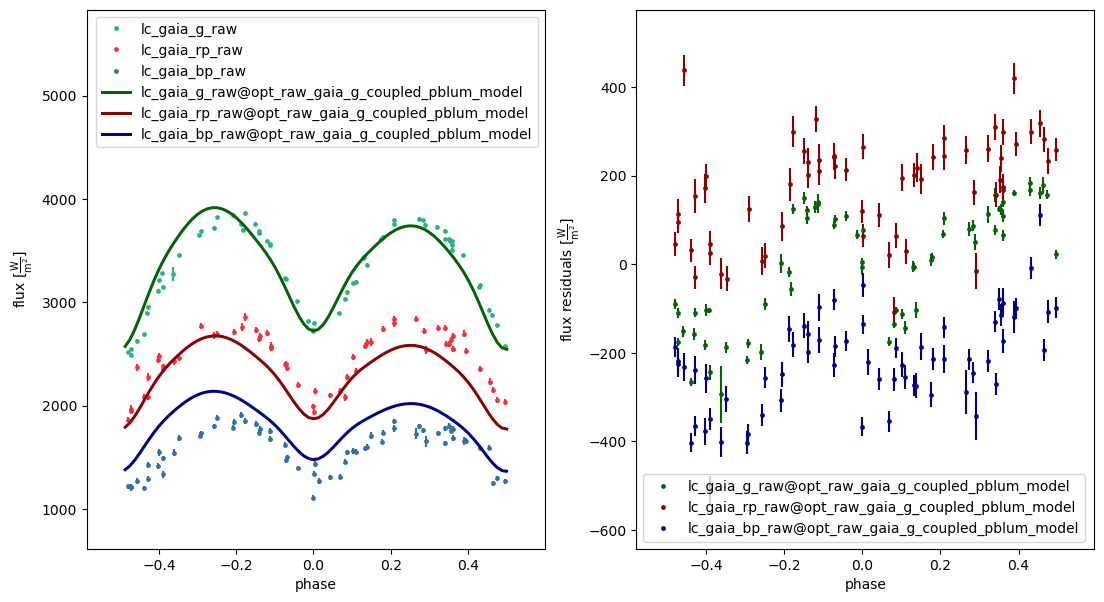

{'lc_gaia_g_raw-lc_gaia_rp_raw-lc_gaia_bp_raw': <Figure size 1300x700 with 2 Axes>}

In [ ]:
# optimize passband luminosity
# solutionPath = gen_solution_path('raw_gaia_g_coupled_pblum_local')
solutionPath = "./external-jobs/updated-data/results/raw_gaia_g_coupled_pblum_local"
if not os.path.exists(solutionPath):
	_, solutionName = opt_utils.optimize_params(b, ['pblum@primary@lc_gaia_g_raw@dataset'], label='raw_gaia_g_coupled_pblum', export=False, 
											 	datasets=['lc_gaia_g_raw'], maxiter=40)
	b.filter(context='solution', solution=solutionName, check_visible=False).save(solutionPath, incl_uniqueid=True)

gen_utils.abilitateDatasets(b, rawGaiaDatasets)
_, computeModelName = opt_utils.adopt_solution(b, reset_params=False, solution_file=solutionPath)
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 7), datasetGroups=[rawGaiaDatasets], model=computeModelName)

# Clean Up Bundle

Remove models, datasets, and solutions that are no longer useful. Reduce bundle size for loading into MCMC sampling phase.

In [161]:
b.models, b.datasets, b.solutions

(['before_optimizers',
  'poro_sample',
  'opt_t0_model',
  'opt_nm_all_model',
  'updated_mesh_phases',
  'secondary_spot_check',
  'opt_secondary_spot_model',
  'all_lcs_secondary_spot',
  'dc_best_solution_model',
  'coupled_model',
  'opt_ztf_teff_model'],
 ['mesh01',
  'lc_iturbide_norm',
  'lc_gaia_g_raw',
  'lc_gaia_rp_raw',
  'lc_gaia_bp_raw',
  'lcZtfG',
  'lcZtfR'],
 ['ebai_knn_all_solution',
  'ebai_knn_ztf_gaia_solution',
  'ebai_knn_iturbide_solution',
  'ebai_knn_iturbide_ztf_solution',
  'ebai_knn_ztf_solution',
  'ebai_knn_raw_gaia_solution',
  'opt_nm_all_solution',
  'opt_secondary_spot_solution',
  'opt_ztf_teff_solution'])

In [162]:
b.remove_solutions_all()
b.remove_models_all()

keepDatasets = ['mesh01', 'lc_iturbide_norm'] + rawGaiaDatasets + ztfDatasets
for d in b.datasets:
	if d not in keepDatasets:
		b.remove_dataset(d)

b.models, b.datasets, b.solutions

([],
 ['mesh01',
  'lc_iturbide_norm',
  'lc_gaia_g_raw',
  'lc_gaia_rp_raw',
  'lc_gaia_bp_raw',
  'lcZtfG',
  'lcZtfR'],
 [])

In [163]:
gen_utils.saveBundle(b, bundleName="post-optimizers", subfolder="updated-data")

Sat, 03 Aug 2024 12:47 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/updated-data/post-optimizers.json.gz'